## IMPORT


In [34]:
import os
import uuid
import re
from concurrent.futures import ThreadPoolExecutor
from functools import lru_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D

import pyodbc
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import connectorx as cx
from sqlalchemy import create_engine
from sqlalchemy.pool import NullPool

# !pip install joblib

from joblib import Parallel, delayed
from tqdm import tqdm

# Configuration
plt.rcParams["font.family"] = ["Noto Sans Khmer", "Noto Sans", "DejaVu Sans"]
pd.set_option("display.float_format", "{:,.2f}".format)
np.set_printoptions(suppress=True, formatter={'float_kind':'{:,.0f}'.format})





In [6]:

# Step 1: Connect to SQL Server
server = "10.10.38.72"             # e.g., "localhost" or "SERVER\\INSTANCE"
port     = 1433 
database = "data_analyst"
username = "analyst"
password = "B$24E$6!9e"

# conn_str = (
#     f"DRIVER={{ODBC Driver 17 for SQL Server}};"
#     f"SERVER={server};"
#     f"DATABASE={database};"
#     f"UID={username};"
#     f"PWD={password}"
# )

# conn = pyodbc.connect(conn_str)
# cursor = conn.cursor()


conn_str = (
    f"mssql+pyodbc://{username}:{password}@{server}/{database}"
    "?driver=ODBC+Driver+17+for+SQL+Server"
)
engine = create_engine(conn_str, fast_executemany=True)


# conn_str = f"mssql://{username}:{password}@{server}:{port}/{database}"



In [7]:
target_group_map = pd.read_csv('target_group_map.csv')
level_care_map = pd.read_csv('level_care_map.csv')
medical_service_map = pd.read_csv('medical_service_map.csv')

In [8]:
english_pattern = re.compile(r'([A-Za-z0-9][A-Za-z0-9\s\-_\/]*)$')

def extract_english_only(df: pd.DataFrame, columns=None) -> pd.DataFrame:
    df = df.copy()

    # Clean column names
    new_columns = []
    for col in df.columns:
        if col.lower() == 'actuarial mapping id':
            new_columns.append(col)  # keep as-is
            continue
        match = english_pattern.search(str(col))
        new_columns.append(match.group(0).strip() if match else col)
    df.columns = new_columns

    # Clean string columns, skip 'Actuarial Mapping ID'
    for col in df.select_dtypes(include=['object']):
        if col.lower() == 'actuarial mapping id':
            continue
        df[col] = df[col].astype(str).apply(
            lambda x: english_pattern.search(x).group(0).strip() if english_pattern.search(x) else ''
        )
    return df


# # Example pattern: keep only English letters, numbers, underscore, and dash
# english_pattern = re.compile(r'[A-Za-z0-9_-]+')

# def extract_english_only(
#     df: pd.DataFrame, 
#     columns_to_clean: list = None,  # NEW: columns to clean
#     skip_columns: list = None       # columns to skip even if in columns_to_clean
# ) -> pd.DataFrame:
#     df = df.copy()

#     if skip_columns is None:
#         skip_columns = []

#     # Clean column names
#     new_columns = []
#     for col in df.columns:
#         if col.lower() in [c.lower() for c in skip_columns]:
#             new_columns.append(col)  # keep as-is
#             continue
#         match = english_pattern.search(str(col))
#         new_columns.append(match.group(0).strip() if match else col)
#     df.columns = new_columns

#     # Determine which columns to clean
#     if columns_to_clean is None:
#         # Default: all object columns except skip_columns
#         columns_to_clean = [col for col in df.select_dtypes(include=['object']).columns 
#                             if col.lower() not in [c.lower() for c in skip_columns]]

#     # Clean only specified columns
#     for col in columns_to_clean:
#         if col not in df.columns or col.lower() in [c.lower() for c in skip_columns]:
#             continue
#         df[col] = df[col].astype(str).apply(
#             lambda x: english_pattern.search(x).group(0).strip() if english_pattern.search(x) else ''
#         )
#     return df


# Strip leading Khmer text
target_group_map = extract_english_only(target_group_map)
level_care_map = extract_english_only(level_care_map)
medical_service_map = extract_english_only(medical_service_map)


In [9]:
target_group_map

,id,Sub-Scheme Family,Sub-Scheme 3,Sub-Scheme 2,Sub-Scheme 1,Scheme,Contributory Types,con_type_code,scheme_code,subscheme1_code,subscheme2_code,subscheme3_code,family_code,code
0,1,nan,PrivateEmployeeNoDependent,PrivateEmployeeNoDependent,PrivateEmployee,PrivateEmployee,Mandatory,1,1,0,1,0,0,110100
1,2,Family Private Employee,PrivateEmployeeWithDependent,PrivateEmployeeWithDependent,PrivateEmployee,PrivateEmployee,Mandatory,1,1,0,2,0,1,110201
2,3,nan,PublicOfficialNoDependent,PublicOfficialNoDependent,PublicOfficial,PublicOfficial,Mandatory,1,2,0,1,0,0,120100
3,4,Family Public Official,PublicOfficialWithDependent,PublicOfficialWithDependent,PublicOfficial,PublicOfficial,Mandatory,1,2,0,2,0,2,120202
4,5,nan,FormerCivilServant,FormerCivilServant,FormerCivilServant,FormerCivilServantVeteran,Mandatory,1,3,1,0,0,0,131000
5,6,nan,FormerVeteran,FormerVeteran,FormerVeteran,FormerCivilServantVeteran,Mandatory,1,3,2,0,0,0,132000
6,7,nan,,,,FormerCivilServantVeteran,Mandatory,1,3,9,0,0,0,139000
7,8,nan,SelfemployedNoDependent,SelfemployedNoDependent,Selfemployed,Selfemployed,Voluntary,2,1,0,1,0,0,210100
8,9,Family Selfemployed,SelfemployedWithDependent,SelfemployedWithDependent,Selfemployed,Selfemployed,Voluntary,2,1,0,2,0,3,210203
9,10,Family Private Employee,PrivateEmployeeDependentSpouse,PrivateEmployeeDependent,PrivateEmployeeDependent,Dependent,Voluntary,2,2,1,0,1,1,221011


In [10]:
medical_service_map

,Detail Medical,Sub-Medical,Medical,Actuarial Mapping ID
0,,,,0
1,Abortion,Abortion,IPD,ABORT
2,Deliveries,Deliveries,IPD,DELIV
3,Emergency Services,Emergency Services,IPD,EMERG
4,FFS Package,FFS Package,IPD,FFSPA
5,FFS Vaccination,Out-patient,OPD,FFSVA
6,IPD Gyneco,In-patient,IPD,IPDGY
7,IPD Medicine,In-patient,IPD,IPDME
8,IPD Pediatric,In-patient,IPD,IPDPE
9,IPD Surgery,In-patient,IPD,IPDSU


In [11]:
level_care_map

,Sub-Level of Care,Level of Care,Types of HF,Actuarial Mapping ID
0,PrivateCPA1,PrivateCPA1,Private HF,PrivateCPA1
1,PrivateCPA2,PrivateCPA2,Private HF,PrivateCPA2
2,PrivateCPA3,PrivateCPA3,Private HF,PrivateCPA3
3,PrivateNH,PrivateNH,Private HF,PrivateNH
4,MPA,MPA,Public HF,MPA
5,CPA1,CPA1,Public HF,CPA1
6,CPA2,CPA2,Public HF,CPA2
7,CPA3,CPA3,Public HF,CPA3
8,NH_Others,NH,Public HF,NH_OT
9,NH_Calmette,NH,Public HF,NH_CA


In [12]:

# Step 2: Write query


###  wage and insurable earning , 
####  => private worker
query1 = """
  SELECT 
    ben_key,
    AVG(salary) AS avg_salary,
    COUNT(*) AS count,
    CASE 
        WHEN AVG(salary) < 400000 THEN 400000
        WHEN AVG(salary) > 1200000 THEN 1200000
        ELSE AVG(salary)
    END AS capped_avg_salary
FROM [DM_REG].[dmrc].[dm_contribution_ben_healthcare]
WHERE ben_type_id = 6
  AND contribute_date >= '2024-09-01'   -- last 12 months
GROUP BY ben_key;

"""


query2 = """
    SELECT total_amount
    FROM [data_analyst].[dbo].[vw_raw_patient_form]
    WHERE is_paid = 'TRUE'
    AND printed_date >= '2020-01-01' 
      AND printed_date < '2025-07-01'
      AND total_amount > 0
    ORDER BY total_amount ASC
"""



query3 = """
    SELECT fee_for_service_amount
    FROM [data_analyst].[dbo].[vw_raw_patient_form]
    WHERE is_paid = 'TRUE'
    AND printed_date >= '2020-01-01' 
      AND printed_date < '2025-07-01'
      AND fee_for_service_amount > 0
    ORDER BY fee_for_service_amount ASC
"""



In [13]:

# df1 = pd.read_sql(query1, conn)
# df2 = pd.read_sql(query2, conn)
# df3 = pd.read_sql(query3, conn)
# df4 = pd.read_sql(query4, conn)


# PLOT


## FUNCTION


#### histrogram

In [14]:
def make_custom_bins(
    ranges,
    bins_per_range,
    max_value=None,
    fmt_labels=True,
    overlap=True,
    integer_labels=True,
    collapse_unit_bins=False,
):
    import numpy as np
    import pandas as pd

    # --- Build bin edges ---
    bin_edges = []
    for i in range(len(bins_per_range)):
        start = ranges[i]
        end = ranges[i+1] if i+1 < len(ranges) else max_value
        edges = np.linspace(start, end, bins_per_range[i] + 1)

        if i > 0:  # avoid duplicate boundary
            edges = edges[1:]

        bin_edges.extend(edges)

    bin_edges = np.array(bin_edges)
    intervals = pd.IntervalIndex.from_breaks(bin_edges, closed="left")

    # --- Formatter helper ---
    def fmt(v):
        if v >= 1_000_000:
            return f"{v/1_000_000:.2f}M".rstrip("0").rstrip(".")
        elif v >= 1_000:
            return f"{v/1_000:.0f}K"
        else:
            return str(int(v))

    # --- Label building ---
    labels = []
    if fmt_labels:
        for iv in intervals:
            width = iv.right - iv.left

            # Special case: collapse to integer if bins are unit width
            if collapse_unit_bins and integer_labels and width == 1:
                labels.append(fmt(iv.left))

            elif overlap:
                labels.append(f"{fmt(iv.left)}–{fmt(iv.right)}")

            else:
                if integer_labels and float(iv.right).is_integer():
                    labels.append(f"{fmt(iv.left)}–{fmt(iv.right - 1)}")
                else:
                    labels.append(f"{fmt(iv.left)}–<{fmt(iv.right)}")
    else:
        labels = [f"{iv.left}-{iv.right}" for iv in intervals]

    return bin_edges, intervals, labels



def plot_binned_distribution(
    series,
    bin_edges,
    labels,
    title="Histogram of Values",
    xlabel="Value range",
    ylabel="Frequency",
    figsize=(12, 8),
    rotation=90,
    hue=None,
    data=None,
    font_family="Noto Sans Khmer",
    hue_consecutive=False,
    gap=1,
    show_pct=True,   # new flag
    pct_decimals=1   # decimal places for % display
):
    """
    Plot histogram/bar chart using custom bins.
    If hue is given:
      - hue_consecutive=True: plot each hue category consecutively with gaps.
      - hue_consecutive=False: grouped bars.
    Optionally adds proportion % annotation relative to each hue category.
    """
    plt.figure(figsize=figsize)

    if hue is None:
        binned = pd.cut(series, bins=bin_edges, right=False, labels=labels)
        bin_counts = binned.value_counts().sort_index()
        ax = plt.bar(bin_counts.index.astype(str), bin_counts.values, edgecolor="black")

        if show_pct:
            total = bin_counts.sum()
            for i, (x, y) in enumerate(zip(range(len(bin_counts)), bin_counts.values)):
                pct = 100 * y / total if total > 0 else 0
                plt.text(x, y, f"{pct:.{pct_decimals}f}%", ha="center", va="bottom")

    else:
        if data is None:
            raise ValueError("If hue is specified, pass the full dataframe as `data`.")

        binned = pd.cut(series, bins=bin_edges, right=False, labels=labels)
        df_tmp = pd.DataFrame({"bin": binned, "hue": data[hue]})
        df_tmp["hue"] = df_tmp["hue"].fillna("Unknown")

        counts = df_tmp.groupby(["bin", "hue"], observed=False).size().unstack(fill_value=0)
        counts = counts.reindex(labels, fill_value=0)

        hues = counts.columns.tolist()
        palette = sns.color_palette("tab10", len(hues))
        color_map = dict(zip(hues, palette))

        # proportions per hue column
        proportions = counts.div(counts.sum(axis=0), axis=1) * 100

        if hue_consecutive:
            x_positions, heights, xticks_labels, colors = [], [], [], []
            current_pos = 0

            for hue_cat in hues:
                values = counts[hue_cat].values
                props = proportions[hue_cat].values
                for i, (val, pct) in enumerate(zip(values, props)):
                    heights.append(val)
                    x_positions.append(current_pos)
                    xticks_labels.append(f" {labels[i]}")
                    colors.append(color_map[hue_cat])
                    if show_pct and val > 0:
                        plt.text(
                            current_pos, val, f"{pct:.{pct_decimals}f}%",
                            ha="center", va="bottom", fontsize=9
                        )
                    current_pos += 1
                current_pos += gap

            ax = plt.bar(x_positions, heights, color=colors, edgecolor="black")
            plt.xticks(x_positions, xticks_labels, rotation=rotation, fontsize=10)

            handles = [plt.Rectangle((0,0),1,1,color=color_map[h]) for h in hues]
            plt.legend(handles, hues, title=hue)

        else:
            ax = counts.plot(
                kind="bar", stacked=False, figsize=figsize,
                edgecolor="black", color=[color_map[h] for h in counts.columns]
            )
            plt.legend(title=hue)

            if show_pct:
                for i, hue_cat in enumerate(hues):
                    for j, (val, pct) in enumerate(zip(counts[hue_cat], proportions[hue_cat])):
                        if val > 0:
                            plt.text(
                                j + (i - len(hues)/2)*0.15,  # shift for grouped bars
                                val,
                                f"{pct:.{pct_decimals}f}%",
                                ha="center", va="bottom", fontsize=9
                            )

    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

    return ax


#### propotion line

In [15]:
def plot_bin_proportion_line(
    series,
    bin_edges,
    labels,
    hue,   # x-axis
    data,
    title="Proportion Line Chart by Bin",
    xlabel="Hue category",
    ylabel="Proportion (%)",
    figsize=(12, 8),
    rotation=45,
    font_family="Noto Sans Khmer",
    crop_y=True,
    margin=0.05,     # margin for cropping y-axis (5%)
    annotate=True,
    pct_decimals=1
):
    """
    Plot line chart of proportions per bin across hue categories.
    Each bin gets its own line.
    Example: x-axis = years, lines = bins.
    """
    if data is None:
        raise ValueError("`data` (full dataframe) must be provided when using hue.")

    # Bin the series
    binned = pd.cut(series, bins=bin_edges, right=False, labels=labels)
    df_tmp = pd.DataFrame({"bin": binned, "hue": data[hue]})
    df_tmp["hue"] = df_tmp["hue"].fillna("Unknown")

    # Count per hue per bin
    counts = df_tmp.groupby(["hue", "bin"], observed=False).size().unstack(fill_value=0)

    # Convert to proportions within each hue
    proportions = counts.div(counts.sum(axis=1), axis=0) * 100

    # Plot
    plt.figure(figsize=figsize)
    for bin_label in proportions.columns:
        yvals = proportions[bin_label]
        plt.plot(
            proportions.index.astype(str),
            yvals,
            marker="o",
            label=str(bin_label)
        )
        if annotate:
            for x, y in zip(proportions.index.astype(str), yvals):
                plt.text(
                    x, y, f"{y:.{pct_decimals}f}%",
                    ha="center", va="bottom", fontsize=9
                )

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)

    # Crop y-axis to focus on variation
    if crop_y:
        ymin, ymax = proportions.min().min(), proportions.max().max()
        yrange = ymax - ymin
        plt.ylim(
            max(0, ymin - margin * yrange),
            min(100, ymax + margin * yrange)
        )
    else:
        plt.ylim(0, 100)

    plt.legend(title="Bin")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


#### boxplot function

In [31]:
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# import re
# from matplotlib.lines import Line2D

# def create_beautiful_boxplot(
#     data: pd.DataFrame, 
#     x_col: str, 
#     y_col: str, 
#     title: str = None, 
#     figsize=(14, 8),
#     palette='Set2',
#     show_annotations=True,
#     drop_non_ascii_labels=False,
#     sort_x: bool = False,
#     annotation_limit: int = 20 , 
#     annotate_quantile = False
# ):
#     """
#     Optimized boxplot with mean, median, Q1, Q3 annotations.

#     Parameters:
#     -----------
#     data : pd.DataFrame
#         Input dataframe.
#     x_col : str
#         Categorical column for x-axis.
#     y_col : str
#         Numerical column for y-axis.
#     title : str, optional
#         Custom plot title.
#     figsize : tuple, optional
#         Figure size.
#     palette : str, optional
#         Seaborn color palette.
#     show_annotations : bool, optional
#         Whether to show mean/median/Q1/Q3 values.
#     drop_non_ascii_labels : bool, optional
#         Remove non-ASCII characters from labels.
#     sort_x : bool, optional
#         Whether to sort x-axis categories alphabetically.
#     annotation_limit : int, optional
#         Max categories to annotate (to avoid slow plots/clutter).
#     """
#     # Optional label sanitization
#     if drop_non_ascii_labels:
#         def sanitize(s): return re.sub(r'[^\x00-\x7F]+', '', str(s))
#         data = data.copy()
#         data[x_col] = data[x_col].apply(sanitize)
#         y_col_sanitized = sanitize(y_col)
#         x_col_sanitized = sanitize(x_col)
#     else:
#         x_col_sanitized, y_col_sanitized = x_col, y_col

#     # Handle x-axis order
#     if sort_x:
#         categories = sorted(data[x_col_sanitized].dropna().unique())
#     else:
#         categories = data[x_col_sanitized].dropna().unique()

#     # --- Precompute stats with groupby (FAST) ---
#     # stats = data.groupby(x_col_sanitized)[y_col_sanitized].agg(
#     #     mean='mean',
#     #     median='median',
#     #     q1=lambda x: np.percentile(x, 25),
#     #     q3=lambda x: np.percentile(x, 75)
#     # )
#     stats = data.groupby(x_col_sanitized)[y_col_sanitized].agg(['mean', 'median'])
#     q1q3 = data.groupby(x_col_sanitized)[y_col_sanitized].apply(
#         lambda x: pd.Series({'q1': np.quantile(x, 0.25), 'q3': np.quantile(x, 0.75)})
#     )
#     stats = pd.concat([stats, q1q3], axis=1)


#     sns.set_style("whitegrid", {'grid.alpha': 0.3})
#     fig, ax = plt.subplots(figsize=figsize, dpi=300)

#     # Boxplot
#     # sns.boxplot(
#     #     x=x_col_sanitized,
#     #     y=y_col_sanitized,
#     #     hue=x_col_sanitized,
#     #     data=data,
#     #     order=categories,
#     #     palette=palette,
#     #     legend=False,
#     #     showfliers=False,
#     #     showmeans=True,
#     #     meanprops={"marker":"D", "markerfacecolor":"#ff6b6b","markeredgecolor":"white","markersize":8},
#     #     boxprops={"alpha":0.7,"edgecolor":"#2d3436"},
#     #     medianprops={"color":"#2d3436","linewidth":3},
#     #     whiskerprops={"color":"#636e72"},
#     #     capprops={"color":"#636e72"},
#     #     ax=ax
#     # )
    
#     sns.boxplot(
#         x=x_col_sanitized,
#         y=y_col_sanitized,
#         data=data,
#         order=categories,
#         palette=palette,
#         showfliers=False,
#         showmeans=False,  # We'll add means manually if needed
#         boxprops={"alpha":0.7,"edgecolor":"#2d3436"},
#         medianprops={"color":"#2d3436","linewidth":3},
#         ax=ax
#     )


#     # --- Optimized annotations ---
#     if show_annotations and len(categories) <= annotation_limit:
#         y_min, y_max = ax.get_ylim()
#         y_range = y_max - y_min

#         # top_categories = stats['mean'].sort_values(ascending=False).head(3).index
#         # bottom_categories = stats['mean'].sort_values(ascending=True).head(3).index
#         # annotate_categories = list(top_categories) + list(bottom_categories)

#         for i, category in enumerate(categories):
#             if category not in stats.index:
#                 continue

#             # Skip every 2nd category to reduce clutter
#             # if i % 2 != 0:
#             #     continue

#             mean_val = stats.loc[category, "mean"]
#             median_val = stats.loc[category, "median"]
#             q1_val = stats.loc[category, "q1"]
#             q3_val = stats.loc[category, "q3"]

#             # Mean
#             ax.annotate(f'μ={mean_val:.1f}', xy=(i, mean_val), 
#                         xytext=(i+0.15, mean_val + 0.02*y_range),
#                         fontsize=9, fontweight='bold', color='#ff6b6b',
#                         bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='#ff6b6b', alpha=0.8),
#                         arrowprops=dict(arrowstyle='->', color='#ff6b6b', lw=1))

#             # Median
#             ax.annotate(f'M={median_val:.1f}', xy=(i, median_val), 
#                         xytext=(i-0.15, median_val + 0.05*y_range),
#                         fontsize=9, fontweight='bold', color='#2d3436',
#                         bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='#2d3436', alpha=0.8),
#                         arrowprops=dict(arrowstyle='->', color='#2d3436', lw=1))

#             if  annotate_quantile :
#                 # Q1
#                 ax.annotate(f'Q1={q1_val:.1f}', xy=(i, q1_val), 
#                             xytext=(i+0.2, q1_val - 0.05*y_range),
#                             fontsize=8, fontweight='bold', color='#0984e3',
#                             bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='#0984e3', alpha=0.8),
#                             arrowprops=dict(arrowstyle='->', color='#0984e3', lw=1))

#                 # Q3
#                 ax.annotate(f'Q3={q3_val:.1f}', xy=(i, q3_val), 
#                             xytext=(i+0.2, q3_val + 0.05*y_range),
#                             fontsize=8, fontweight='bold', color='#6c5ce7',
#                             bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='#6c5ce7', alpha=0.8),
#                             arrowprops=dict(arrowstyle='->', color='#6c5ce7', lw=1))



#     # Title & labels
#     if title is None:
#         title = f'Distribution of {y_col_sanitized} by {x_col_sanitized}'
#         if show_annotations: title += '\nwith Mean (μ), Median (M), Q1, Q3'
#     ax.set_title(title, fontsize=18, fontweight='bold', color='#2d3436', pad=30)
#     ax.set_xlabel(x_col_sanitized.replace('_',' ').title(), fontsize=16, fontweight='bold', color='#2d3436', )
#     ax.set_ylabel(y_col_sanitized.replace('_',' ').title(), fontsize=16, fontweight='bold', color='#2d3436')

#     # Legend
#     legend_elements = [
#         Line2D([0],[0], marker='D', color='w', markerfacecolor='#ff6b6b', markersize=8, markeredgecolor='white', label='Mean (μ)'),
#         Line2D([0],[0], color='#2d3436', linewidth=3, label='Median (M)'),
#         Line2D([0],[0], color='#0984e3', linewidth=2, label='Q1'),
#         Line2D([0],[0], color='#6c5ce7', linewidth=2, label='Q3')
#     ]
#     ax.legend(handles=legend_elements, loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=11)

#     plt.xticks(rotation=70)
    
#     ax.set_facecolor('#fafafa')
#     fig.patch.set_facecolor('white')
#     plt.tight_layout()
#     return fig, ax



def create_beautiful_boxplot(
    data: pd.DataFrame,
    x_col: str,
    y_col: str,
    title: str = None,
    figsize=(14, 8),
    palette="Set2",
    show_annotations=True,
    drop_non_ascii_labels=False,
    sort_x: bool = False,
    annotation_limit: int = 20,
    annotate_quantile: bool = False,
):
    """
    Optimized boxplot with mean, median, Q1, Q3 annotations.
    """

    # Optional label sanitization
    if drop_non_ascii_labels:
        def sanitize(s): return re.sub(r"[^\x00-\x7F]+", "", str(s))
        data = data.copy()
        data[x_col] = data[x_col].apply(sanitize)
        y_col_sanitized = sanitize(y_col)
        x_col_sanitized = sanitize(x_col)
    else:
        x_col_sanitized, y_col_sanitized = x_col, y_col

    # Handle x-axis order
    if sort_x:
        categories = sorted(data[x_col_sanitized].dropna().unique())
    else:
        categories = data[x_col_sanitized].dropna().unique()

    # --- Precompute stats with groupby (FAST) ---
    stats = data.groupby(x_col_sanitized)[y_col_sanitized].agg(
        mean="mean",
        median="median",
        q1=lambda x: x.quantile(0.25),
        q3=lambda x: x.quantile(0.75),
    )

    sns.set_style("whitegrid", {"grid.alpha": 0.3})
    fig, ax = plt.subplots(figsize=figsize, dpi=150)

    # Boxplot
    sns.boxplot(
        x=x_col_sanitized,
        y=y_col_sanitized,
        hue=x_col_sanitized,
        data=data,
        order=categories,
        palette=palette,
        legend=False,
        showfliers=False,
        showmeans=True,
        meanprops={
            "marker": "D",
            "markerfacecolor": "#ff6b6b",
            "markeredgecolor": "white",
            "markersize": 8,
        },
        boxprops={"alpha": 0.7, "edgecolor": "#2d3436"},
        medianprops={"color": "#2d3436", "linewidth": 3},
        whiskerprops={"color": "#636e72"},
        capprops={"color": "#636e72"},
        ax=ax,
    )

    # --- Optimized annotations ---
    if show_annotations and len(categories) <= annotation_limit:
        y_min, y_max = ax.get_ylim()
        y_range = y_max - y_min

        for i, category in enumerate(categories):
            if category not in stats.index:
                continue

            mean_val = stats.loc[category, "mean"]
            median_val = stats.loc[category, "median"]
            q1_val = stats.loc[category, "q1"]
            q3_val = stats.loc[category, "q3"]

            # Mean
            ax.annotate(
                f"μ={mean_val:.1f}",
                xy=(i, mean_val),
                xytext=(i + 0.15, mean_val + 0.02 * y_range),
                fontsize=8,
                fontweight="bold",
                color="#ff6b6b",
                bbox=dict(
                    boxstyle="round,pad=0.3",
                    facecolor="white",
                    edgecolor="#ff6b6b",
                    alpha=0.7,
                ),
                arrowprops=dict(arrowstyle="->", color="#ff6b6b", lw=1),
            )

            # Median
            ax.annotate(
                f"M={median_val:.1f}",
                xy=(i, median_val),
                xytext=(i - 0.15, median_val + 0.04 * y_range),
                fontsize=8,
                fontweight="bold",
                color="#2d3436",
                bbox=dict(
                    boxstyle="round,pad=0.3",
                    facecolor="white",
                    edgecolor="#2d3436",
                    alpha=0.7,
                ),
                arrowprops=dict(arrowstyle="->", color="#2d3436", lw=1),
            )

            if annotate_quantile:
                # Q1
                ax.annotate(
                    f"Q1={q1_val:.1f}",
                    xy=(i, q1_val),
                    xytext=(i + 0.2, q1_val - 0.05 * y_range),
                    fontsize=7,
                    color="#0984e3",
                    bbox=dict(
                        boxstyle="round,pad=0.3",
                        facecolor="white",
                        edgecolor="#0984e3",
                        alpha=0.7,
                    ),
                    arrowprops=dict(arrowstyle="->", color="#0984e3", lw=1),
                )
                # Q3
                ax.annotate(
                    f"Q3={q3_val:.1f}",
                    xy=(i, q3_val),
                    xytext=(i + 0.2, q3_val + 0.05 * y_range),
                    fontsize=7,
                    color="#6c5ce7",
                    bbox=dict(
                        boxstyle="round,pad=0.3",
                        facecolor="white",
                        edgecolor="#6c5ce7",
                        alpha=0.7,
                    ),
                    arrowprops=dict(arrowstyle="->", color="#6c5ce7", lw=1),
                )

    # Title & labels
    if title is None:
        title = f"Distribution of {y_col_sanitized} by {x_col_sanitized}"
        if show_annotations:
            title += "\nwith Mean (μ), Median (M), Q1, Q3"
    ax.set_title(title, fontsize=14, fontweight="bold", color="#2d3436", pad=20)
    ax.set_xlabel(
        x_col_sanitized.replace("_", " ").title(),
        fontsize=12,
        fontweight="bold",
        color="#2d3436",
    )
    ax.set_ylabel(
        y_col_sanitized.replace("_", " ").title(),
        fontsize=12,
        fontweight="bold",
        color="#2d3436",
    )

    # Legend
    legend_elements = [
        Line2D(
            [0],
            [0],
            marker="D",
            color="w",
            markerfacecolor="#ff6b6b",
            markersize=8,
            markeredgecolor="white",
            label="Mean (μ)",
        ),
        Line2D([0], [0], color="#2d3436", linewidth=3, label="Median (M)"),
    ]
    if annotate_quantile:
        legend_elements.extend(
            [
                Line2D([0], [0], color="#0984e3", linewidth=2, label="Q1"),
                Line2D([0], [0], color="#6c5ce7", linewidth=2, label="Q3"),
            ]
        )
    ax.legend(
        handles=legend_elements,
        loc="upper right",
        frameon=True,
        fancybox=True,
        shadow=True,
        fontsize=9,
    )

    plt.xticks(rotation=70)
    ax.set_facecolor("#fafafa")
    fig.patch.set_facecolor("white")
    plt.tight_layout()
    return fig, ax


#### distribution function

In [17]:

def plot_distribution_curves(
    data,
    x_col,
    y_col,
    cap_method=None,
    downsample_size=50_000,
    bins=100,
    random_state=42,
    plot_type="kde",
    figsize=(16, 9),
    show_stats=True
):
    np.random.seed(random_state)
    fig, ax = plt.subplots(figsize=figsize)

    categories = sorted(data[x_col].unique())
    colors = sns.color_palette("tab10", len(categories))

    # Compute global cap
     # Compute global cap
    caps = []
    mins = []
    for cat in categories:
        vals = data.loc[data[x_col]==cat, y_col].dropna().values
        if len(vals)==0:
            caps.append(0)
            mins.append(np.inf)
            continue
        if cap_method=="quantile":
            cap = np.percentile(vals, 95)
        elif cap_method=="iqr":
            q1, q3 = np.percentile(vals,[25,75])
            cap = q3 + 1.5*(q3-q1)
        else:
            cap = np.max(vals)
        caps.append(cap)
        mins.append(np.min(vals))

    global_cap = max(caps)
    global_min = min(mins) 

    # Fixed vertical positions in axes fraction (top to bottom)
    mean_y_positions = np.linspace(0.95, 0.95 - 0.05*(len(categories)-1), len(categories))
    median_y_positions = np.linspace(0.95, 0.95 - 0.05*(len(categories)-1), len(categories))

    # Adjusted x positions inside axes to avoid legend overlap
    right_x = 0.8
    left_x = 0.1

    for i, (cat, color) in enumerate(zip(categories, colors)):
        grp = data[data[x_col]==cat]
        values = grp[y_col].dropna().values
        if len(values)==0:
            continue

        mean_val = values.mean()
        median_val = np.median(values)

        plot_values = np.clip(values, None, global_cap)
        if len(plot_values) > downsample_size:
            plot_values = np.random.choice(plot_values, downsample_size, replace=False)

        # Plot KDE or histogram
        if plot_type=="kde":
            sns.kdeplot(plot_values, label=str(cat), ax=ax, clip=(global_min, global_cap), warn_singular=False)
        else:
            sns.histplot(plot_values, bins=bins, stat="density", ax=ax, element="step", color=color)

        if show_stats:
            # Vertical lines
            ax.axvline(mean_val, color=color, linestyle='-', linewidth=2, alpha=0.7)
            ax.axvline(median_val, color=color, linestyle='--', linewidth=2, alpha=0.7)

            # Boxes for annotation
            bbox_props = dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor=color, alpha=0.8)

            # --- Horizontal arrows ---
            # Mean → right
            ax.annotate(f'{mean_val:.1f}',
                        xy=(mean_val, mean_y_positions[i]), xycoords=('data','axes fraction'),
                        xytext=(right_x, mean_y_positions[i]), textcoords='axes fraction',
                        arrowprops=dict(arrowstyle="->", color=color, lw=2),
                        ha='right', va='center', fontsize=10, color=color,
                        bbox=bbox_props)

            # Median → left
            ax.annotate(f'{median_val:.1f}',
                        xy=(median_val, median_y_positions[i]), xycoords=('data','axes fraction'),
                        xytext=(left_x, median_y_positions[i]), textcoords='axes fraction',
                        arrowprops=dict(arrowstyle="->", color=color, lw=2),
                        ha='left', va='center', fontsize=10, color=color,
                        bbox=bbox_props)
    
    ax.set_xlim(global_min, global_cap)  # <<--- force x-axis limits

    ax.set_title(f"Distribution of {y_col} by {x_col} \n vertical line: mean\n dash line: median", fontsize=16, fontweight='bold')
    ax.set_xlabel(y_col, fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.legend(title=x_col, fontsize=11, title_fontsize=12, loc='upper right')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig, ax




### group plot

In [35]:

def save_grouped_custom_plots(
    df,
    group_cols,
    x_col,
    y_col,
    output_dir="plots",
    plot_func=None,
    plot_kwargs=None,
    title_prefix=None,
    parallel: bool = True,
    n_jobs: int = -1,
    dpi: int = 100,
):
    """
    Generate and save plots for each group combination efficiently.
    """

    os.makedirs(output_dir, exist_ok=True)
    plot_kwargs = plot_kwargs or {}

    # Wrapper for one group
    def process_group(group_vals, df_filtered):
        fig, ax = plot_func(
            df_filtered[[x_col, y_col]],
            x_col=x_col,
            y_col=y_col,
            **plot_kwargs,
        )

        # Title
        title_parts = [f"{col}: {val}" for col, val in zip(group_cols, group_vals)]
        prefix = (
            f"{title_prefix} of {y_col} by {x_col}"
            if title_prefix
            else f"{y_col} by {x_col}"
        )
        ax.set_title(prefix + "\n" + " | ".join(title_parts), fontsize=12)

        # Nested folders: all but last column
        folder_parts = [
            str(val).strip().replace("/", "-").replace("\\", "-")
            for val in group_vals[:-1]
        ]
        nested_dir = os.path.join(output_dir, *folder_parts)
        os.makedirs(nested_dir, exist_ok=True)

        # Filename from last col
        safe_value = str(group_vals[-1]).strip().replace("/", "-").replace("\\", "-")
        filepath = os.path.join(nested_dir, f"{safe_value}.png")

        plt.savefig(filepath, bbox_inches="tight", dpi=dpi)
        plt.close(fig)

    # --- Iterate with groupby (efficient) ---
    groups = list(df.groupby(group_cols))
    print(f"Generating {len(groups)} plots...")

    if parallel:
        Parallel(n_jobs=n_jobs)(
            delayed(process_group)(group_vals, df_filtered)
            for group_vals, df_filtered in tqdm(groups, desc="Creating plots")
        )
    else:
        for group_vals, df_filtered in tqdm(groups, desc="Creating plots"):
            process_group(group_vals, df_filtered)


# from tqdm import tqdm

# def save_grouped_custom_plots(
#     df,
#     group_cols,
#     x_col,
#     y_col,
#     output_dir="plots",
#     plot_func=None,
#     plot_kwargs=None,
#     title_prefix=None
# ):
#     os.makedirs(output_dir, exist_ok=True)
#     plot_kwargs = plot_kwargs or {}

#     # Get unique combinations
#     group_combos = df[group_cols].dropna().drop_duplicates()
    
#     print(f"Generating {len(group_combos)} plots...")
    
#     # Create progress bar
#     for group_vals, df_filtered in df.groupby(group_cols):

#         # Call custom plot function
#         fig, ax = plot_func(
#             df_filtered[[x_col, y_col]], 
#             x_col=x_col, 
#             y_col=y_col, 
#             **plot_kwargs
#         )

#         # Title
#         title_parts = [f"{col}: {row[col]}" for col in group_cols]
#         prefix = f"{title_prefix} of {y_col} by {x_col}" if title_prefix else f"{y_col} by {x_col}"
#         ax.set_title(prefix + "\n" + " | ".join(title_parts), fontsize=14)

#         # Create nested folder structure using values directly
#         folder_parts = []
#         for i, col in enumerate(group_cols[:-1]):  # All but the last column become folders
#             safe_value = str(row[col]).strip().replace("/", "-").replace("\\", "-")
#             folder_parts.append(safe_value)
        
#         # Create the nested directory structure
#         nested_dir = os.path.join(output_dir, *folder_parts)
#         os.makedirs(nested_dir, exist_ok=True)

#         # Filename uses the last grouping column value
#         last_col = group_cols[-1]
#         safe_value = str(row[last_col]).strip().replace("/", "-").replace("\\", "-")
#         filename = f"{safe_value}.png"
#         filepath = os.path.join(nested_dir, filename)

#         # Save
#         plt.savefig(filepath, bbox_inches="tight", dpi=150)
#         plt.close(fig)


## WAGE

In [52]:

###  wage and insurable earning , 
####  => private worker
query1 = """
  SELECT 
    ben_key,
    AVG(salary) AS avg_salary,
    COUNT(*) AS count,
    CASE 
        WHEN AVG(salary) < 400000 THEN 400000
        WHEN AVG(salary) > 1200000 THEN 1200000
        ELSE AVG(salary)
    END AS capped_avg_salary
FROM [DM_REG].[dmrc].[dm_contribution_ben_healthcare]
WHERE ben_type_id = 6                   -- private worker
  AND contribute_date >= '2024-09-01'   -- last 12 months
GROUP BY ben_key;

"""

df1 = pd.read_sql(query1, conn)

NameError: name 'conn' is not defined

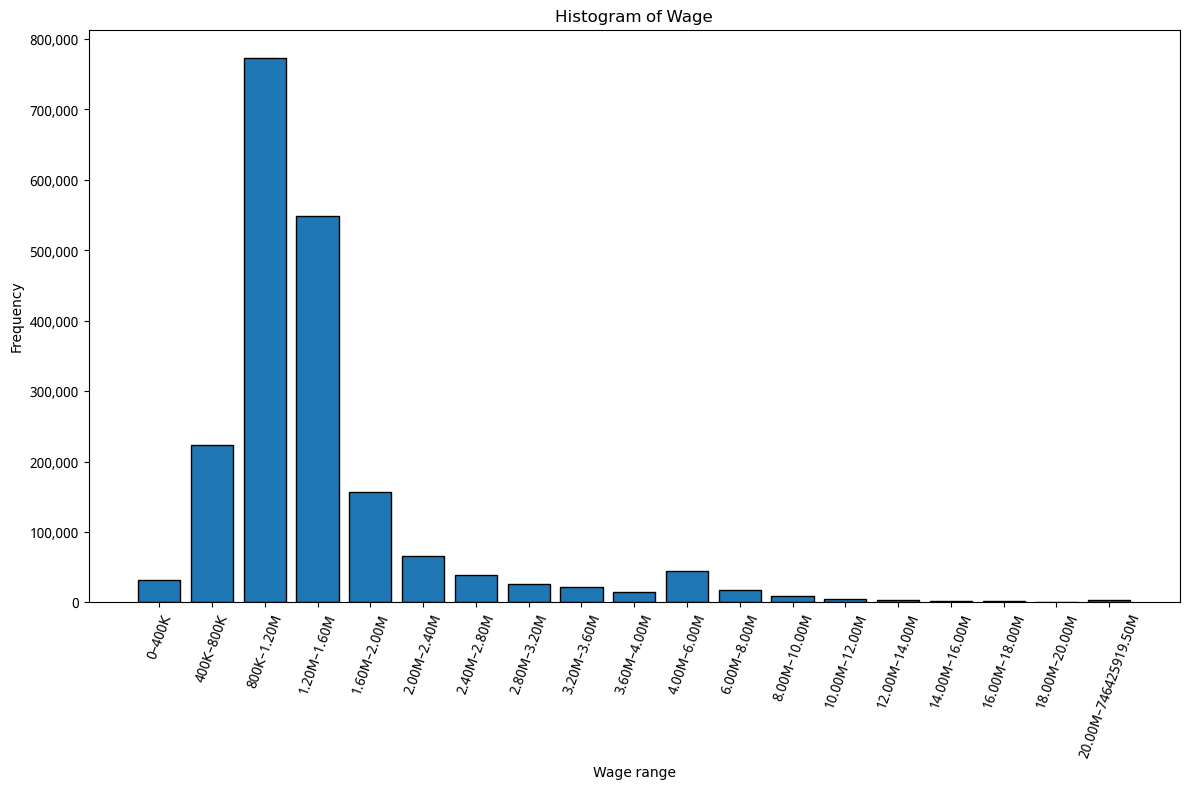

In [7]:
separators = [0, 4000000, 20000000,]
bins = [10, 8, 1]

bin_edges, intervals, labels = make_custom_bins(separators, bins, max_value=df1["avg_salary"].max())

plot_binned_distribution(
    df1["avg_salary"], 
    bin_edges, 
    labels, 
    title="Histogram of Wage", 
    xlabel="Wage range", 
    ylabel="Frequency"
)

In [8]:
summary = df1['avg_salary'].describe(percentiles=[.25, .5, .75, .9, .95, .99])
summary.to_clipboard()
summary

count             1,990,208.00
mean            376,623,467.66
std         529,099,653,441.20
min                     200.00
25%                 966,526.89
50%               1,186,435.47
75%               1,487,012.80
90%               2,311,486.84
95%               3,664,034.72
99%               8,980,080.33
max     746,425,919,500,259.00
Name: avg_salary, dtype: float64

## Insurable earning

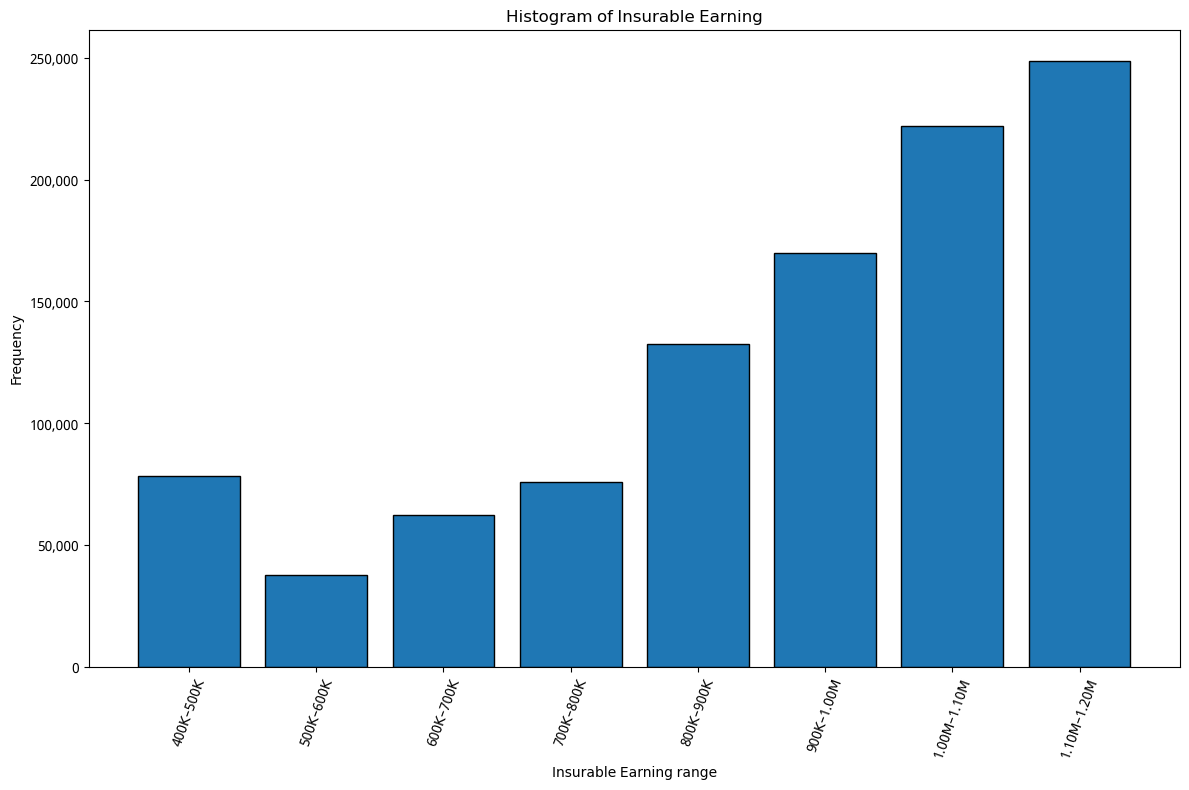

In [9]:
separators = [400000, 1200000]
bins = [8]

bin_edges, intervals, labels = make_custom_bins(separators, bins, max_value=df1["capped_avg_salary"].max())

plot_binned_distribution(
    df1["capped_avg_salary"], 
    bin_edges, 
    labels, 
    title="Histogram of Insurable Earning", 
    xlabel="Insurable Earning range", 
    ylabel="Frequency"
)


In [10]:
summary = df1['capped_avg_salary'].describe(percentiles=[.25, .5, .75, .9, .95, .99])
summary.to_clipboard()
summary

count   1,990,208.00
mean    1,054,578.18
std       212,689.60
min       400,000.00
25%       966,526.89
50%     1,186,435.47
75%     1,200,000.00
90%     1,200,000.00
95%     1,200,000.00
99%     1,200,000.00
max     1,200,000.00
Name: capped_avg_salary, dtype: float64

## TOTAL AMOUNT


In [11]:

query3 = """
---------------------------------------------------------------------------
-- STEP 0: Drop existing temp tables
---------------------------------------------------------------------------
DROP TABLE IF EXISTS ##normalized_consumption;
DROP TABLE IF EXISTS ##amount_data;

DECLARE @filtered_first_date DATE = '2020-01-01', @filtered_end_date DATE = '2025-12-31';

---------------------------------------------------------------------------
-- STEP 1: Normalize Healthcare Consumption + Dependents
---------------------------------------------------------------------------
SELECT
    tb1.*,
    CASE 
        WHEN DATEDIFF(MONTH, tb1.dob, tb1.visit_date) % 12 >= 7 
            THEN DATEDIFF(MONTH, tb1.dob, tb1.visit_date)/12 + 1
        ELSE DATEDIFF(MONTH, tb1.dob, tb1.visit_date)/12
    END AS AgeInYears,
    DATEDIFF(DAY, tb1.visit_date , tb1.discharge_date) as medical_stay_day
INTO ##normalized_consumption
FROM (
    SELECT 
		A.Code, A.visit_date, A.case_name, A.hea_fac_type, A.hea_package_level,
        A.hea_fac_id, A.case_base_amount, A.fee_for_service_amount,
        A.gender, A.dob , A.discharge_date, 
        COALESCE(
            CASE 
                WHEN B.targed_group IN (
                    N'អ្នកក្នុងបន្ទុក-មន្ត្រីជាប់កិច្ចសន្យា', N'អ្នកក្នុងបន្ទុក-មន្ត្រីនគរបាលជាតិ', N'អ្នកក្នុងបន្ទុក-មន្ត្រីរាជការស៊ីវិល',
                    N'អ្នកក្នុងបន្ទុក-មន្រ្តីក្រុមប្រឹក្សារដ្ឋធម្មនុញ្ញ', N'អ្នកក្នុងបន្ទុក-មន្រ្តីនយោបាយ', N'អ្នកក្នុងបន្ទុក-មន្រ្តីព្រឹទ្ធសភា',
                    N'អ្នកក្នុងបន្ទុក-មន្រ្តីរដ្ឋសភា', N'អ្នកក្នុងបន្ទុក-អតីតមន្ត្រីរាជការ', N'អ្នកក្នុងបន្ទុក-អតីតយុទ្ធជន',
                    N'អ្នកក្នុងបន្ទុក-ក្រុមប្រឹក្សា', N'អ្នកក្នុងបន្ទុក-ការិយាល័យប្រជាពលរដ្ឋ'
                ) THEN 12
                WHEN B.targed_group IN (
                    N'អ្នកក្នុងបន្ទុក-មន្ត្រីជាប់កិច្ចសន្យា', N'អ្នកក្នុងបន្ទុក-មន្ត្រីនគរបាលជាតិ', N'អ្នកក្នុងបន្ទុក-មន្ត្រីរាជការស៊ីវិល',
                    N'អ្នកក្នុងបន្ទុក-មន្រ្តីក្រុមប្រឹក្សារដ្ឋធម្មនុញ្ញ', N'អ្នកក្នុងបន្ទុក-មន្រ្តីនយោបាយ', N'អ្នកក្នុងបន្ទុក-មន្រ្តីព្រឹទ្ធសភា',
                    N'អ្នកក្នុងបន្ទុក-មន្រ្តីរដ្ឋសភា', N'អ្នកក្នុងបន្ទុក-អតីតមន្ត្រីរាជការ', N'អ្នកក្នុងបន្ទុក-អតីតយុទ្ធជន',
                    N'អ្នកក្នុងបន្ទុក-ក្រុមប្រឹក្សា', N'អ្នកក្នុងបន្ទុក-ការិយាល័យប្រជាពលរដ្ឋ'
                ) AND A.targeted_group_id <> 14 THEN 15
                WHEN B.targed_group = N'អ្នកក្នុងបន្ទុក-កម្មករនិយោជិត' THEN 9
                WHEN B.targed_group = N'អ្នកក្នុងបន្ទុក-កម្មករនិយោជិត' AND A.targeted_group_id <> 14 THEN 12
                WHEN B.targed_group = N'អ្នកក្នុងបន្ទុក-បុគ្គលស្វ័យនិយោជន៍' THEN 15
                WHEN B.targed_group = N'អ្នកក្នុងបន្ទុក-បុគ្គលស្វ័យនិយោជន៍' AND A.targeted_group_id <> 14 THEN 18
            END + CASE WHEN B.relationship = N'កូន' THEN 2 ELSE 1 END,
            CASE
                WHEN A.targeted_group_id = 6 AND C.code_parent IS NULL THEN 1
                WHEN A.targeted_group_id = 6 AND C.code_parent IS NOT NULL THEN 2
                WHEN A.targeted_group_id IN (1,3,5,9,10,11,13,15,16,17) AND C.code_parent IS NULL THEN 3
                WHEN A.targeted_group_id IN (1,3,5,9,10,11,13,15,16,17) AND C.code_parent IS NOT NULL THEN 4
                WHEN A.targeted_group_id = 2 THEN 5
                WHEN A.targeted_group_id = 4 THEN 6
                WHEN A.targeted_group_id = 12 AND C.code_parent IS NULL THEN 8
                WHEN A.targeted_group_id = 12 AND C.code_parent IS NOT NULL THEN 9
                ELSE 999
            END
        ) AS target_group_id
    FROM data_analyst.dbo.td_ben_healthcare_consumption A
    LEFT JOIN data_analyst.dbo.td_dependent B
        ON A.Code = B.Code AND A.targeted_group_id = 14
    LEFT JOIN (
        SELECT DISTINCT code_parent, MIN(contract_date) AS contract_date
        FROM data_analyst.dbo.RAW_DEPENDENT
        GROUP BY code_parent
    ) C ON A.Code = C.code_parent AND CAST(A.visit_date AS DATE) >= C.contract_date
    WHERE A.is_paid = 1
      AND A.visit_date BETWEEN @filtered_first_date AND @filtered_end_date
) tb1;

---------------------------------------------------------------------------
-- STEP 2: Compute Amounts and Join Dimension Details
---------------------------------------------------------------------------
SELECT 
    YEAR(visit_date) AS Visit_Year,
    MONTH(visit_date) AS Visit_Month,
    f.visit_date,
    f.discharge_date,
    f.gender,
    f.AgeInYears,

    f.medical_stay_day,
    
    -- Amount calculations
    CASE WHEN dm1.[លម្អិតសេវាព្យាបាល Detail Medical] IN (N'សេវាទូទាត់ជាកញ្ចប់ FFS Package', N'វ៉ាក់សាំង/សេរ៉ូម FFS Vaccination') 
         THEN f.case_base_amount + f.fee_for_service_amount 
         ELSE f.fee_for_service_amount END AS Total_Amount_FFS,
    CASE WHEN dm1.[លម្អិតសេវាព្យាបាល Detail Medical] IN (N'សេវាទូទាត់ជាកញ្ចប់ FFS Package', N'វ៉ាក់សាំង/សេរ៉ូម FFS Vaccination') 
         THEN 0 ELSE f.case_base_amount END AS Total_Amount_CB,
    f.case_base_amount + f.fee_for_service_amount AS Total_Amount,

    

    -- Target Group details
    tg.[របបភាគទាន Contributory Types],
    tg.[ក្រុមគោលដៅ Scheme],
    tg.[ក្រុមគោលដៅលម្អិតកម្រិត១ Sub-Scheme 1],
    tg.[ក្រុមគោលដៅលម្អិតកម្រិត២ Sub-Scheme 2],
    tg.[ក្រុមគោលដៅលម្អិតកម្រិត៣ Sub-Scheme 3],
    tg.[ក្រុមគោលដៅលម្អិតជាគ្រួសារ Sub-Scheme Family],
    
    -- Medical Service details
    CASE WHEN f.hea_fac_type = 'Private' 
     AND dm1.[លម្អិតសេវាព្យាបាល Detail Medical] = N'សេវាទូទាត់ជាកញ្ចប់ FFS Package' 
     THEN N'វ៉ាក់សាំង/សេរ៉ូម FFS Vaccination' 
     ELSE dm1.[លម្អិតសេវាព្យាបាល Detail Medical] END AS Detail_Medical,
    dm1.[សេវាព្យាបាល Sub-Medical],
    dm1.[សេវាព្យាបាលគោល Medical],
    
    
    -- Health Facility details
    dm2.[លម្អិតកម្រិតទូទាត់ Sub-Level of Care],
    dm2.[កម្រិតទូទាត់ Level of Care],
    dm2.[កម្រិតទូទាត់គោល Types of HF]


INTO ##amount_data
FROM ##normalized_consumption f
LEFT JOIN data_analyst.dbo.RAW_LIST_TARGETGROUP_V2 tg ON f.target_group_id = tg.id
LEFT JOIN data_analyst.dbo.RAW_LIST_MEDICALSERVICE dm1 ON TRIM(f.case_name) = TRIM(dm1.[Case Name])
LEFT JOIN data_analyst.dbo.RAW_LIST_HEALTHFACILITY dm2  
    ON f.hea_fac_type = dm2.Type  
   AND f.hea_package_level = dm2.[Package Level]  
   AND IIF(f.hea_fac_id IN (1259,1258,1262,1261,1704,1488,1265), f.hea_fac_id, 999999999) = dm2.hea_fac_id;

---------------------------------------------------------------------------
-- STEP 3: Final Output (Raw Individual Data)
---------------------------------------------------------------------------
SELECT top 100 * FROM ##amount_data;
"""


In [20]:
to_do = 0

if to_do:


    chunksize = 1000_000
    base_dir = "amount_data_parquet_test"
    os.makedirs(base_dir, exist_ok=True)

    # --- Ensure partition folder exists ---
    @lru_cache(maxsize=None)
    def ensure_dir(year):
        path = os.path.join(base_dir, f"visit_year={year}")
        os.makedirs(path, exist_ok=True)
        return path

    # --- Query ---
    query = "SELECT  * FROM ##amount_data"  # keep visit_year first for clarity

    # --- Process in chunks ---
    with engine.connect() as conn:
        for i, chunk in enumerate(pd.read_sql(query, conn, chunksize=chunksize)):
            for year, year_df in chunk.groupby("Visit_Year"):
                outdir = ensure_dir(year)
                outfile = os.path.join(outdir, f"part_{i}.parquet")
                year_df.to_parquet(outfile, engine="pyarrow", index=False)
            print(f"Processed chunk {i}, rows: {len(chunk)}")

    print("✅ Export complete.")

In [21]:
base_dir = "amount_data_parquet"

# Read all parquet files recursively
df_claim = pd.read_parquet(base_dir, engine="pyarrow")



In [22]:
df_claim.head()

,Visit_Year,Visit_Month,visit_date,discharge_date,gender,AgeInYears,medical_stay_day,Total_Amount_FFS,Total_Amount_CB,Total_Amount,id,Detail_Medical_Code,Level_Care_Code,visit_year
0,2020,12,2020-12-05,2020-12-05,F,38,0,0.00,"36,000.00","36,000.00",1.00,OPDCS,PrivateCPA3,2020
1,2020,1,2020-01-28,2020-01-28,F,26,0,0.00,"36,000.00","36,000.00",1.00,OPDCS,PrivateCPA3,2020
2,2020,6,2020-06-26,2020-06-26,F,48,0,0.00,"36,000.00","36,000.00",3.00,OPDCS,PrivateCPA3,2020
3,2020,12,2020-12-19,2020-12-25,F,25,6,0.00,"400,000.00","400,000.00",1.00,IPDGY,NH_OT,2020
4,2020,9,2020-09-03,2020-09-04,M,46,1,"30,000.00","36,000.00","66,000.00",1.00,OPDCS,PrivateCPA3,2020


In [23]:
len(df_claim)

24727395

In [24]:
df_claim = pd.merge(df_claim,medical_service_map,
                     how="left", left_on="Detail_Medical_Code", right_on="Actuarial Mapping ID")

In [25]:
df_claim = pd.merge(df_claim,level_care_map,
                     how="left", left_on="Level_Care_Code", right_on="Actuarial Mapping ID")

In [26]:
df_claim = pd.merge(df_claim,target_group_map,
                     how="left", left_on="id", right_on="id")

In [27]:
df_claim.head()

,Visit_Year,Visit_Month,visit_date,discharge_date,gender,AgeInYears,medical_stay_day,Total_Amount_FFS,Total_Amount_CB,Total_Amount,...,Sub-Scheme 1,Scheme,Contributory Types,con_type_code,scheme_code,subscheme1_code,subscheme2_code,subscheme3_code,family_code,code
0,2020,12,2020-12-05,2020-12-05,F,38,0,0.00,"36,000.00","36,000.00",...,PrivateEmployee,PrivateEmployee,Mandatory,1.00,1.00,0.00,1.00,0.00,0.00,"110,100.00"
1,2020,1,2020-01-28,2020-01-28,F,26,0,0.00,"36,000.00","36,000.00",...,PrivateEmployee,PrivateEmployee,Mandatory,1.00,1.00,0.00,1.00,0.00,0.00,"110,100.00"
2,2020,6,2020-06-26,2020-06-26,F,48,0,0.00,"36,000.00","36,000.00",...,PublicOfficial,PublicOfficial,Mandatory,1.00,2.00,0.00,1.00,0.00,0.00,"120,100.00"
3,2020,12,2020-12-19,2020-12-25,F,25,6,0.00,"400,000.00","400,000.00",...,PrivateEmployee,PrivateEmployee,Mandatory,1.00,1.00,0.00,1.00,0.00,0.00,"110,100.00"
4,2020,9,2020-09-03,2020-09-04,M,46,1,"30,000.00","36,000.00","66,000.00",...,PrivateEmployee,PrivateEmployee,Mandatory,1.00,1.00,0.00,1.00,0.00,0.00,"110,100.00"


### all


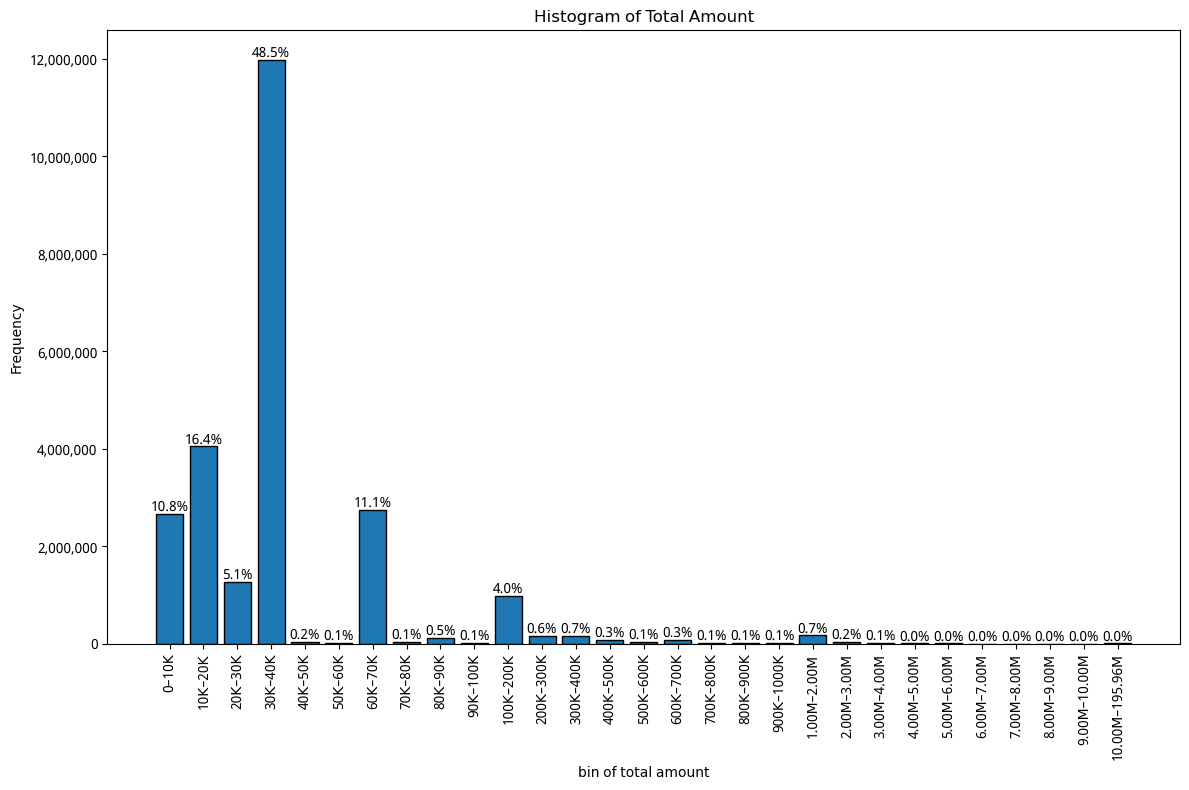

<BarContainer object of 29 artists>

In [28]:
separators = [0,100000, 1000000,  10000000]
bins = [10,9,9,1]

bin_edges, intervals, labels = make_custom_bins(separators, bins, max_value=df_claim["Total_Amount"].max(), overlap=False)

plot_binned_distribution(
    df_claim["Total_Amount"], 
    bin_edges, 
    labels, 
    title="Histogram of Total Amount", 
    xlabel="bin of total amount", 
    ylabel="Frequency",
    # hue='Visit_Year',
    # data=df_claim,
    # hue_consecutive=True
)

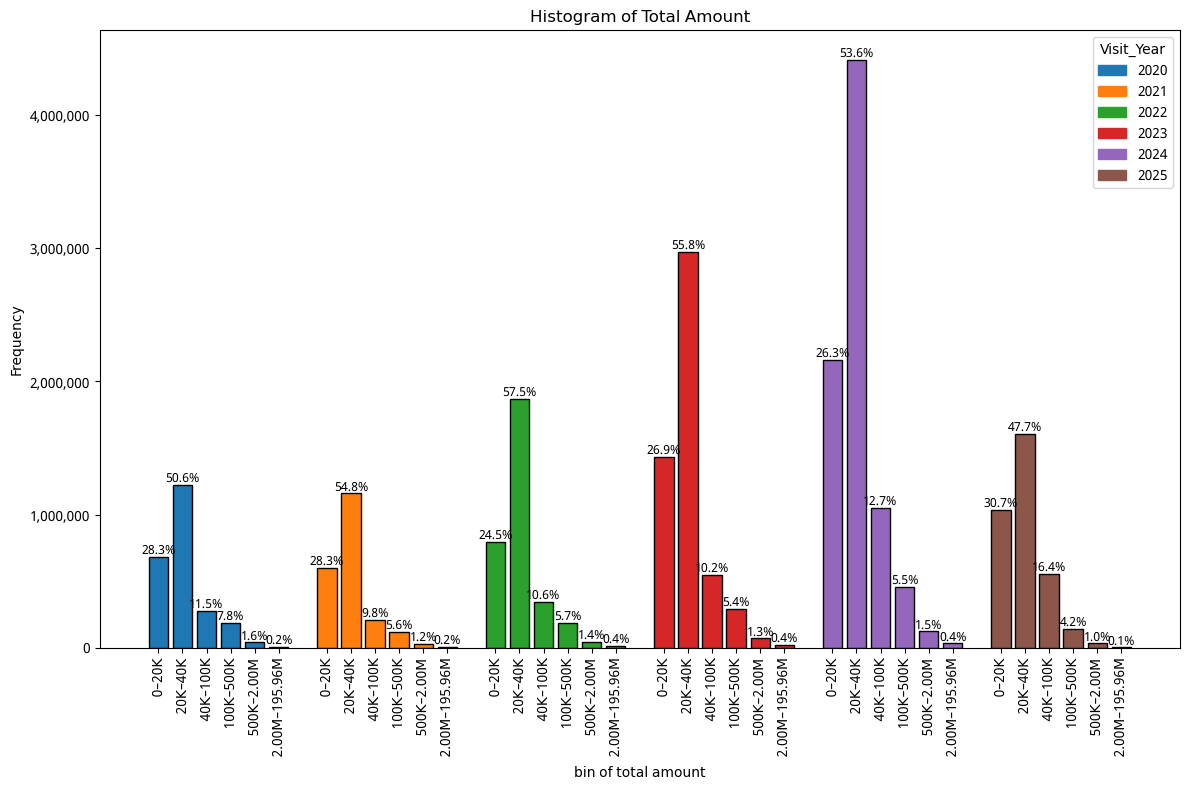

<BarContainer object of 36 artists>

In [21]:
separators = [0,40000, 100000, 500000, 2000000]
bins = [2,1,1,1,1]

bin_edges, intervals, labels = make_custom_bins(separators, bins, max_value=df_claim["Total_Amount"].max(), overlap=False)

plot_binned_distribution(
    df_claim["Total_Amount"], 
    bin_edges, 
    labels, 
    title="Histogram of Total Amount", 
    xlabel="bin of total amount", 
    ylabel="Frequency",
    hue='Visit_Year',
    data=df_claim,
    hue_consecutive=True
)

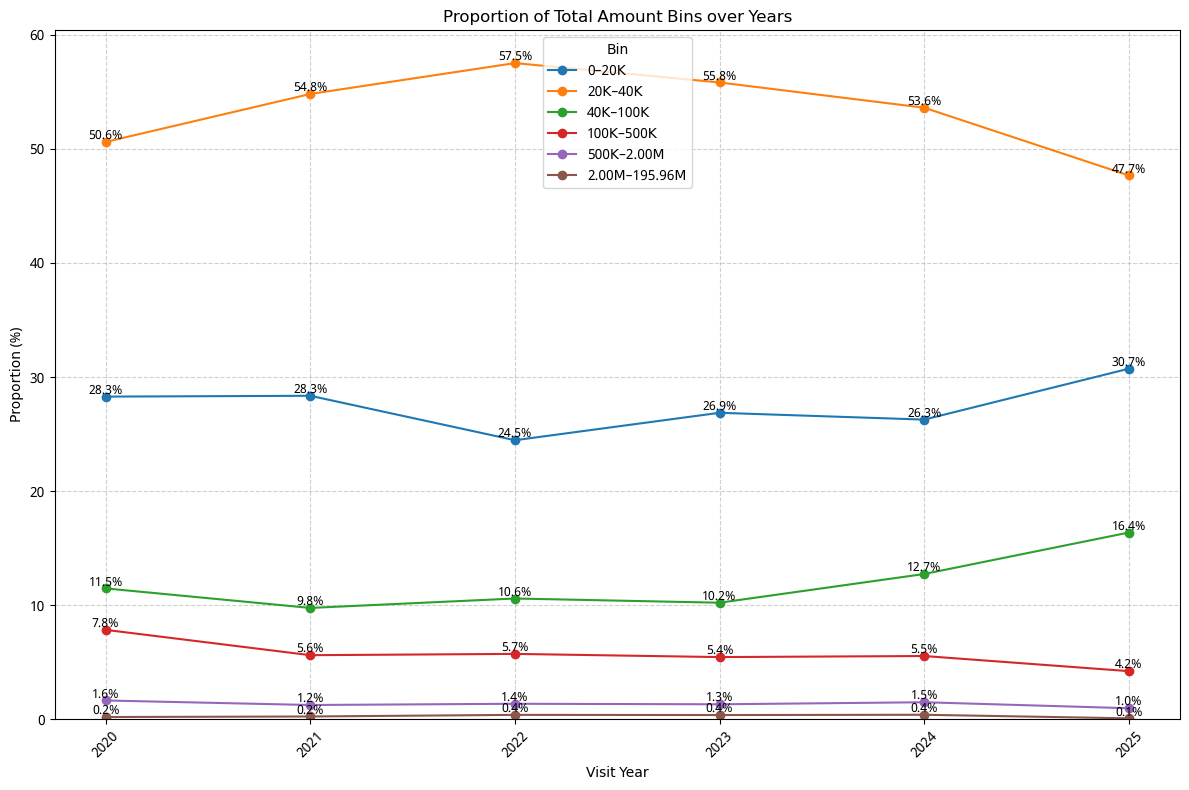

In [22]:
plot_bin_proportion_line(
    series=df_claim["Total_Amount"],
    bin_edges=bin_edges,
    labels=labels,
    hue="Visit_Year",   # x-axis
    data=df_claim,
    title="Proportion of Total Amount Bins over Years",
    xlabel="Visit Year",
    ylabel="Proportion (%)",
    rotation=45
)


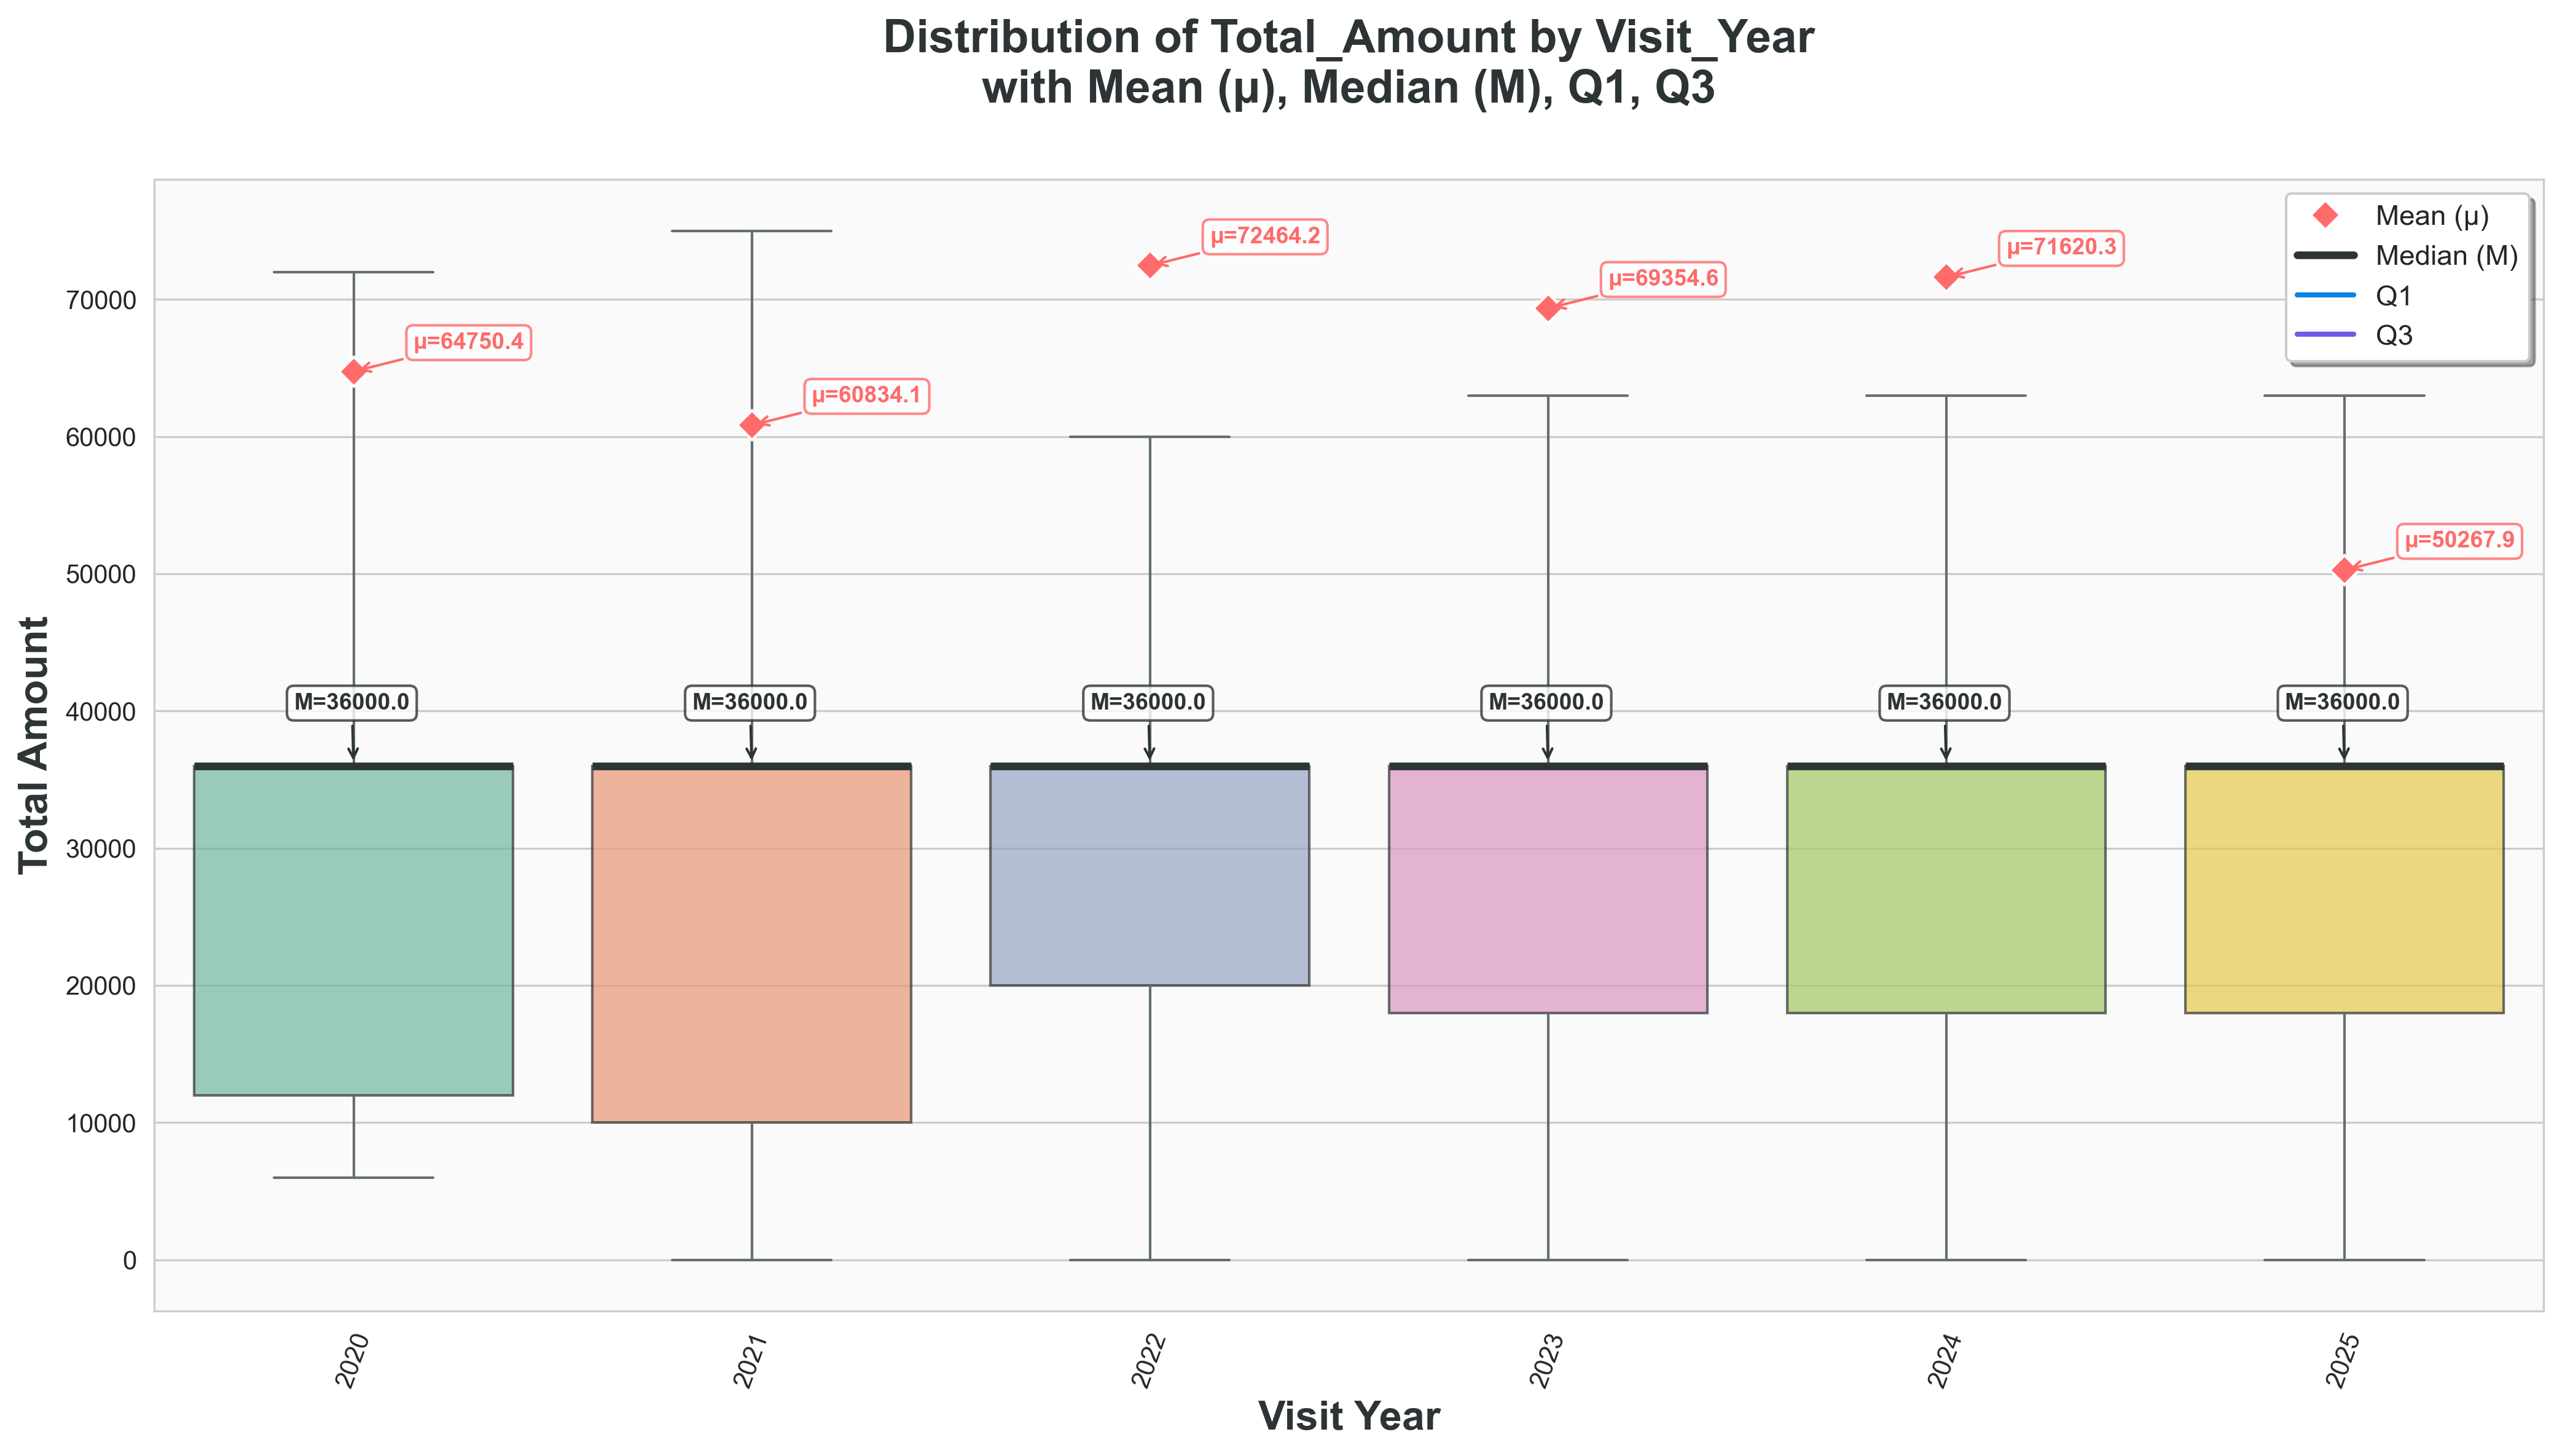

In [23]:
fig, ax = create_beautiful_boxplot(
    data=df_claim[["Visit_Year", "Total_Amount"]], 
    x_col='Visit_Year', 
    y_col='Total_Amount'
)
plt.show()

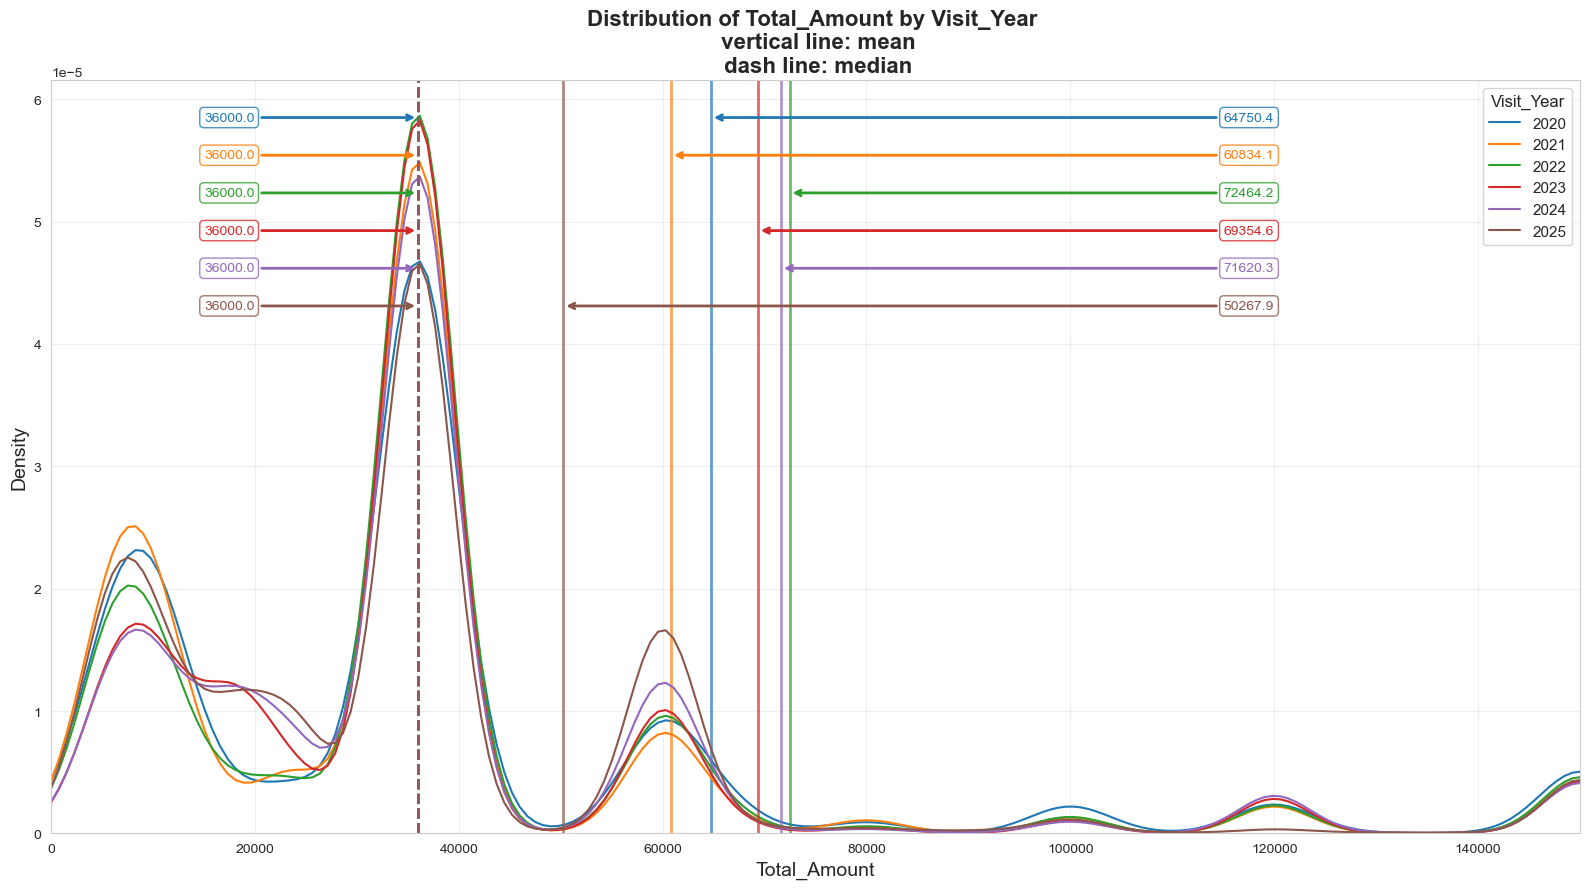

In [24]:
fig, ax = plot_distribution_curves(
    data=df_claim,
    x_col='Visit_Year',
    y_col='Total_Amount',
    cap_method='quantile'
)
plt.show()


### by medical service + level care

In [ ]:
group_combos = df_claim[['Sub-Medical', 'Level of Care', 'Sub-Scheme 3']].dropna()

SyntaxError: invalid syntax (1027596455.py, line 1)

In [ ]:
group_combos

,Sub-Medical,Level of Care,Sub-Scheme 3
0,Out-patient,PrivateCPA3,PrivateEmployeeNoDependent
1,Out-patient,PrivateCPA3,PrivateEmployeeNoDependent
2,Out-patient,PrivateCPA3,PublicOfficialNoDependent
3,In-patient,NH,PrivateEmployeeNoDependent
4,Out-patient,PrivateCPA3,PrivateEmployeeNoDependent
...,...,...,...
24727390,Out-patient,NH,FormerCivilServant
24727391,Out-patient,NH,FormerCivilServant
24727392,Out-patient,NH,FormerVeteran
24727393,Out-patient,NH,FormerCivilServant


##### boxplot

In [38]:
import multiprocessing

# total cores
n_cores = multiprocessing.cpu_count()

# use ~70%
n_jobs = max(1, int(n_cores * 0.7))
print(f"Using {n_jobs} workers out of {n_cores} cores")


Using 8 workers out of 12 cores


In [ ]:

save_grouped_custom_plots(
    df=df_claim,
    group_cols=["Detail Medical"],
    # group_cols=["Detail Medical", "Sub-Level of Care"],
    # group_cols=["Detail Medical", "Sub-Level of Care", "Sub-Scheme 3"],
    x_col="Visit_Year",
    y_col="Total_Amount",
    output_dir="results/total_amount/boxplot",
    plot_func=create_beautiful_boxplot,
    plot_kwargs={"sort_x": True, "show_annotations": True, "annotation_limit": 15},
    title_prefix="Boxplot",
    parallel=True,   # 🚀 parallelize across CPU cores
    n_jobs=8,       # use all cores
    dpi=100          # reduce file size & save time
)



Generating 15 plots...


Creating plots: 100%|██████████| 15/15 [00:00<00:00, 306.22it/s]


#### distribution

In [43]:


save_grouped_custom_plots(
    df=df_claim,
    group_cols=["Detail Medical"],
    # group_cols=["Detail Medical", "Sub-Level of Care"],
    # group_cols=["Detail Medical", "Sub-Level of Care", "Sub-Scheme 3"],
    x_col="Visit_Year",
    y_col="Total_Amount",
    output_dir="results/total_amount/distributions",
    plot_func=plot_distribution_curves,
    plot_kwargs={"plot_type": "kde", "show_stats": True, "cap_method": "quantile"},
    title_prefix="Distribution",
    parallel=True,   # 🚀 parallelize across CPU cores
    n_jobs=8,       # use all cores
    dpi=100          # reduce file size & save time
)

Generating 15 plots...


Creating plots: 100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


## FFS

### all


In [45]:
df_ffs = df_claim[df_claim['Total_Amount_FFS']!=0]

In [46]:
df_ffs.head()

,Visit_Year,Visit_Month,visit_date,discharge_date,gender,AgeInYears,medical_stay_day,Total_Amount_FFS,Total_Amount_CB,Total_Amount,...,Sub-Scheme 1,Scheme,Contributory Types,con_type_code,scheme_code,subscheme1_code,subscheme2_code,subscheme3_code,family_code,code
4,2020,9,2020-09-03,2020-09-04,M,46,1,"30,000.00","36,000.00","66,000.00",...,PrivateEmployee,PrivateEmployee,Mandatory,1.00,1.00,0.00,1.00,0.00,0.00,"110,100.00"
57,2020,9,2020-09-02,2020-09-03,M,36,1,"30,000.00","36,000.00","66,000.00",...,PrivateEmployee,PrivateEmployee,Mandatory,1.00,1.00,0.00,1.00,0.00,0.00,"110,100.00"
97,2020,1,2020-01-26,2020-01-27,F,31,1,"60,000.00","180,000.00","240,000.00",...,PrivateEmployee,PrivateEmployee,Mandatory,1.00,1.00,0.00,1.00,0.00,0.00,"110,100.00"
185,2020,1,2020-01-06,2020-01-06,F,33,0,"25,300.00","60,000.00","85,300.00",...,PrivateEmployee,PrivateEmployee,Mandatory,1.00,1.00,0.00,1.00,0.00,0.00,"110,100.00"
203,2020,1,2020-01-07,2020-01-07,F,33,0,"25,300.00","60,000.00","85,300.00",...,PrivateEmployee,PrivateEmployee,Mandatory,1.00,1.00,0.00,1.00,0.00,0.00,"110,100.00"


#### boxplot

In [49]:
# save_grouped_custom_plots(
#     df=df_ffs,
#     group_cols=["Sub-Medical", "Sub-Level of Care"],
#     x_col="Visit_Year",
#     y_col="Total_Amount_FFS",
#     output_dir="FFS_AMOUNT/boxplots",
#     plot_func=create_beautiful_boxplot,
#     plot_kwargs={"sort_x": True},
#     title_prefix="Boxplot"
# )

save_grouped_custom_plots(
    df=df_ffs,
    # group_cols=["Detail Medical"],
    # group_cols=["Detail Medical", "Sub-Level of Care"],
    group_cols=["Detail Medical", "Sub-Level of Care", "Sub-Scheme 3"],
    x_col="Visit_Year",
    y_col="Total_Amount_FFS",
    output_dir="results/ffs_amount/boxplot",
    plot_func=create_beautiful_boxplot,
    plot_kwargs={"sort_x": True, "show_annotations": True, "annotation_limit": 15},
    title_prefix="Boxplot",
    parallel=True,   # 🚀 parallelize across CPU cores
    n_jobs=8,       # use all cores
    dpi=100          # reduce file size & save time
)



Generating 1296 plots...


Creating plots: 100%|██████████| 1296/1296 [02:15<00:00,  9.55it/s]


#### distribution

In [52]:
# save_grouped_custom_plots(
#     df=df_ffs,
#     group_cols=["Sub-Medical", "Sub-Level of Care"],
#     x_col="Visit_Year",
#     y_col="Total_Amount_FFS",
#     output_dir="FFS_AMOUNT/distributions",
#     plot_func=plot_distribution_curves,
#     plot_kwargs={"plot_type": "kde", "show_stats": True, "cap_method": "quantile"},
#     title_prefix="Distribution"
# )




save_grouped_custom_plots(
    df=df_ffs,
    # group_cols=["Detail Medical"],
    # group_cols=["Detail Medical", "Sub-Level of Care"],
    group_cols=["Detail Medical", "Sub-Level of Care", "Sub-Scheme 3"],
    x_col="Visit_Year",
    y_col="Total_Amount_FFS",
    output_dir="results/ffs_amount/distributions",
    plot_func=plot_distribution_curves,
    plot_kwargs={"plot_type": "kde", "show_stats": True, "cap_method": "quantile"},
    title_prefix="Distribution",
    parallel=True,   # 🚀 parallelize across CPU cores
    n_jobs=8,       # use all cores
    dpi=100          # reduce file size & save time
)

Generating 1296 plots...


Creating plots: 100%|██████████| 1296/1296 [02:07<00:00, 10.16it/s]


## SICKLEAVE DAY

In [14]:

query5 = """
---------------------------------------------------------------------------
-- STEP 0: Drop existing temp tables
---------------------------------------------------------------------------
DROP TABLE IF EXISTS #table_contribution;
DROP TABLE IF EXISTS #normalized_consumption;
DROP TABLE IF EXISTS #joined_data;
DROP TABLE IF EXISTS #amount_data;
DROP TABLE IF EXISTS summary_result_actuarial_healthcare_sickness;

---------------------------------------------------------------------------
-- STEP 1: Contribution Table (Keep Highest Salary per Member per Month)
---------------------------------------------------------------------------
SELECT 
    ranked.ent_key,
	ranked.unique_id,
	--MAX(RANKED.contribute_date) OVER (PARTITION BY RANKED.unique_id) AS MAX_CONTRIBUTION_DATE, --might use later to match address
    ranked.unique_id + '-' + CAST(YEAR(ranked.contribute_date) AS VARCHAR(4)) + '-' 
        + CAST(MONTH(ranked.contribute_date) AS VARCHAR(2)) AS key_join
INTO #table_contribution
FROM (
    SELECT 
        D.unique_id, 
        B.ent_key, 
        B.salary, 
        B.contribute_date,
        ROW_NUMBER() OVER (
            PARTITION BY D.unique_id, B.contribute_date 
            ORDER BY B.salary DESC, B.ent_key DESC
        ) AS rn
    FROM NSSF_DWH.rc.dim_beneficiary D
    LEFT JOIN DM_REG.dmrc.dm_contribution_ben_healthcare B 
        ON B.ben_key = D.ben_key
    WHERE B.contribute_date >= (select min(hospitalization_date) from td_beneficiary_sick_leave)
) ranked
WHERE rn = 1;

-- Index for faster join
CREATE INDEX idx_key_join ON #table_contribution(key_join);

---------------------------------------------------------------------------
-- STEP 2: Normalize Healthcare Consumption + Dependents
---------------------------------------------------------------------------
SELECT
    tb1.*,
	 CASE 
        WHEN HFA.hea_fac_typ_desc = N'ឯកជន' THEN 'Private'
        WHEN HFA.hea_fac_typ_desc = N'សាធារណៈ' THEN 'Public'
        ELSE 'Error'
    END AS HEA_FAC_TYPE,
    CASE 
        WHEN HFA.pac_lev_code = 'PR' THEN 'CPA 1'
        WHEN HFA.hea_fac_id IN (1838, 1856) THEN 'NH'
        WHEN HFA.pac_lev_code = 'MPA Plus' THEN 'MPA'
        WHEN HFA.pac_lev_code = 'MPA_CPA' THEN 'CPA 1'
        WHEN HFA.pac_lev_code = 'P1' THEN 'CPA 1'
        WHEN HFA.pac_lev_code = 'P2' THEN 'CPA 2'
        WHEN HFA.pac_lev_code = 'P3' THEN 'CPA 3'
        WHEN HFA.pac_lev_code = 'CPA1' THEN 'CPA 1'
        WHEN HFA.pac_lev_code = 'CPA2' THEN 'CPA 2'
        WHEN HFA.pac_lev_code = 'CPA3' THEN 'CPA 3'
        ELSE HFA.pac_lev_code
    END AS PAC_LEV_CODE,
    CASE 
        WHEN DATEDIFF(MONTH, tb1.dob, tb1.hospitalization_date) % 12 >= 7 
            THEN DATEDIFF(MONTH, tb1.dob, tb1.hospitalization_date)/12 + 1
        ELSE DATEDIFF(MONTH, tb1.dob, tb1.hospitalization_date)/12
    END AS AgeInYears,
    tb1.code + '-' + CAST(YEAR(tb1.hospitalization_date) AS VARCHAR(4)) + '-' 
        + CAST(MONTH(tb1.hospitalization_date) AS VARCHAR(2)) AS key_join
INTO #normalized_consumption
FROM 
			(
				-- Main members + dependents
				SELECT
					COALESCE(
						CASE 
							WHEN B.targed_group IN (
								N'អ្នកក្នុងបន្ទុក-មន្ត្រីជាប់កិច្ចសន្យា',
								N'អ្នកក្នុងបន្ទុក-មន្ត្រីនគរបាលជាតិ',
								N'អ្នកក្នុងបន្ទុក-មន្ត្រីរាជការស៊ីវិល',
								N'អ្នកក្នុងបន្ទុក-មន្រ្តីក្រុមប្រឹក្សារដ្ឋធម្មនុញ្ញ',
								N'អ្នកក្នុងបន្ទុក-មន្រ្តីនយោបាយ',
								N'អ្នកក្នុងបន្ទុក-មន្រ្តីព្រឹទ្ធសភា',
								N'អ្នកក្នុងបន្ទុក-មន្រ្តីរដ្ឋសភា',
								N'អ្នកក្នុងបន្ទុក-អតីតមន្ត្រីរាជការ',
								N'អ្នកក្នុងបន្ទុក-អតីតយុទ្ធជន',
								N'អ្នកក្នុងបន្ទុក-ក្រុមប្រឹក្សា',
								N'អ្នកក្នុងបន្ទុក-ការិយាល័យប្រជាពលរដ្ឋ'
							) THEN N'អ្នកក្នុងបន្ទុក-មន្រ្តីសាធារណៈ' 
							ELSE B.targed_group END
						+ ' (' + CASE WHEN B.relationship = N'កូន' THEN N'កូន' ELSE N'សហព័ទ្ធ' END + ')',
						CASE
							WHEN A.targeted_group_id = 6 THEN N'កម្មករនិយោជិត'
							WHEN A.targeted_group_id = 2 THEN N'អតីតមន្រី្តរាជការ'
							WHEN A.targeted_group_id = 4 THEN N'អតីតយុទ្ធជន'
							WHEN A.targeted_group_id = 12 THEN N'បុគ្គលស្វ័យនិយោជន៍'
							WHEN A.targeted_group_id IN (1,3,5,9,10,11,13,15,16,17) THEN N'មន្រ្តីសាធារណៈ'
							ELSE 'Unmatched' END
					) AS target_groups,
					A.Code, A.hospitalization_date, A.amount, A.number_of_day_claim, A.hea_fac_id,
					A.gender, A.dob
				FROM data_analyst.dbo.td_beneficiary_sick_leave A
				LEFT JOIN data_analyst.dbo.td_dependent B
					ON A.Code = B.Code AND A.targeted_group_id = 14

				UNION ALL

				-- Heads of household for dependents
				SELECT
					CASE
						WHEN B.targeted_group_id = 6 THEN N'កម្មករនិយោជិត'
						WHEN B.targeted_group_id = 12 THEN N'បុគ្គលស្វ័យនិយោជន៍'
						WHEN B.targeted_group_id IN (1,2,3,4,5,9,10,11,13,15,16,17) THEN N'មន្រ្តីសាធារណៈ'
					END + N'-មេគ្រួសារ' AS target_groups,
					B.Code, B.hospitalization_date, B.amount, B.number_of_day_claim, B.hea_fac_id,
					B.gender, B.dob
				FROM data_analyst.dbo.td_beneficiary_sick_leave B
				LEFT JOIN (
					SELECT DISTINCT code_parent, MIN(contract_date) AS contract_date
					FROM data_analyst.dbo.RAW_DEPENDENT
					GROUP BY code_parent
				) C ON B.code = C.code_parent
				WHERE B.targeted_group <> N'អ្នកក្នុងបន្ទុក'
				  AND CAST(B.hospitalization_date AS DATE) >= C.contract_date
				  AND B.code IN (SELECT DISTINCT code_parent FROM data_analyst.dbo.RAW_DEPENDENT)
			) tb1

		Left join vw_health_facility_address_all HFA
			on tb1.hea_fac_id = HFA.hea_fac_id;

-- Index for faster join
CREATE INDEX idx_norm_key_join ON #normalized_consumption(key_join);

---------------------------------------------------------------------------
-- STEP 3: Join Contributions
---------------------------------------------------------------------------
SELECT n.*, c.ent_key
INTO #joined_data
FROM #normalized_consumption n
LEFT JOIN #table_contribution c
    ON n.key_join = c.key_join;

---------------------------------------------------------------------------
-- STEP 4: Compute Amounts and Add Dimensions
---------------------------------------------------------------------------
SELECT 
    YEAR(hospitalization_date) AS Hospitalization_Year,
    MONTH(hospitalization_date) AS Hospitalization_Month,
	amount AS Total_Amount,
	number_of_day_claim as Number_of_Day_Claim,
    CASE WHEN gender='F' THEN N'ស្រី Female' ELSE N'ប្រុស Male' END AS [ភេទ Gender],
    dm0.[លម្អិតក្រុមគោលដៅ Detail Scheme], dm0.[ក្រុមគោលដៅ Scheme], 
    dm0.[ប្រភេទគ្រួសារ Family Package], dm0.[របបភាគទាន Contributory Types],
	dm2.[លម្អិតកម្រិតទូទាត់ Sub-Level of Care], dm2.[កម្រិតទូទាត់ Level of Care], dm2.[កម្រិតទូទាត់គោល Types of HF],
    dm3.[លម្អិតរាជធានី-ខេត្ត Provinces], dm3.[រាជធានី-ខេត្ត Location], dm3.[តំបន់ Region],
    dm4.Sector, dm4.Category, dm4.[Sub-category 1],
    dm5.[ក្រុមអាយុ Age Group]
INTO #amount_data
FROM #joined_data j
LEFT JOIN RAW_LIST_TARGETGROUP dm0 ON j.target_groups = dm0.[target groups]
LEFT JOIN RAW_LIST_HEALTHFACILITY dm2 
    ON j.hea_fac_type = dm2.Type 
   AND j.PAC_LEV_CODE = dm2.[Package Level]
   AND IIF(j.hea_fac_id IN (1259,1258,1262,1261,1704,1488,1265), j.hea_fac_id, 999999999) = dm2.hea_fac_id
LEFT JOIN vw_ent_address dm3_1 ON j.ent_key = dm3_1.ent_key
LEFT JOIN RAW_LIST_LOCATION dm3 ON dm3_1.pro_id = dm3.pro_id
LEFT JOIN data_analyst.dbo.RAW_LIST_SECTOR dm4 ON dm3_1.business_type_code = dm4.business_type_code
LEFT JOIN data_analyst.dbo.RAW_LIST_AGEGROUP dm5 ON j.AgeInYears = dm5.[Individual Age];

---------------------------------------------------------------------------
-- STEP 5: Aggregate Results
---------------------------------------------------------------------------
SELECT 
    Hospitalization_Year, Hospitalization_Month,
    Number_of_Day_Claim,
    [លម្អិតក្រុមគោលដៅ Detail Scheme], [ក្រុមគោលដៅ Scheme], 
    [ប្រភេទគ្រួសារ Family Package], [របបភាគទាន Contributory Types],
    [លម្អិតកម្រិតទូទាត់ Sub-Level of Care], [កម្រិតទូទាត់ Level of Care], [កម្រិតទូទាត់គោល Types of HF]
FROM #amount_data







SELECT * 
FROM #amount_data
WHERE [កម្រិតទូទាត់គោល Types of HF] is null
"""

In [15]:
df5 = pd.read_csv('sickleave.csv')

In [16]:
df5.head()

,Hospitalization_Year,Hospitalization_Month,Number_of_Day_Claim,លម្អិតក្រុមគោលដៅ Detail Scheme,ក្រុមគោលដៅ Scheme,ប្រភេទគ្រួសារ Family Package,របបភាគទាន Contributory Types,លម្អិតកម្រិតទូទាត់ Sub-Level of Care,កម្រិតទូទាត់ Level of Care,កម្រិតទូទាត់គោល Types of HF
0,2024,8,14,កម្មករនិយោជិត PrivateEmployee,កម្មករនិយោជិត PrivateEmployee,NaN,កាតព្វកិច្ច Mandatory,មន្ទីរពេទ្យព្រះអង្គឌួង NH_Angduong,មន្ទីរពេទ្យថ្នាក់ជាតិ NH,មូលដ្ឋានសុខាភិបាលសាធារណៈ Public HF
1,2020,2,14,កម្មករនិយោជិត PrivateEmployee,កម្មករនិយោជិត PrivateEmployee,NaN,កាតព្វកិច្ច Mandatory,មន្ទីរពេទ្យព្រះអង្គឌួង NH_Angduong,មន្ទីរពេទ្យថ្នាក់ជាតិ NH,មូលដ្ឋានសុខាភិបាលសាធារណៈ Public HF
2,2022,10,14,កម្មករនិយោជិត PrivateEmployee,កម្មករនិយោជិត PrivateEmployee,NaN,កាតព្វកិច្ច Mandatory,មន្ទីរពេទ្យព្រះអង្គឌួង NH_Angduong,មន្ទីរពេទ្យថ្នាក់ជាតិ NH,មូលដ្ឋានសុខាភិបាលសាធារណៈ Public HF
3,2020,1,14,កម្មករនិយោជិត PrivateEmployee,កម្មករនិយោជិត PrivateEmployee,NaN,កាតព្វកិច្ច Mandatory,មន្ទីរពេទ្យព្រះអង្គឌួង NH_Angduong,មន្ទីរពេទ្យថ្នាក់ជាតិ NH,មូលដ្ឋានសុខាភិបាលសាធារណៈ Public HF
4,2019,12,14,កម្មករនិយោជិត PrivateEmployee,កម្មករនិយោជិត PrivateEmployee,NaN,កាតព្វកិច្ច Mandatory,មន្ទីរពេទ្យព្រះអង្គឌួង NH_Angduong,មន្ទីរពេទ្យថ្នាក់ជាតិ NH,មូលដ្ឋានសុខាភិបាលសាធារណៈ Public HF


In [17]:
df5.columns

Index(['Hospitalization_Year', 'Hospitalization_Month', 'Number_of_Day_Claim',
       'លម្អិតក្រុមគោលដៅ Detail Scheme', 'ក្រុមគោលដៅ Scheme',
       'ប្រភេទគ្រួសារ Family Package', 'របបភាគទាន Contributory Types',
       'លម្អិតកម្រិតទូទាត់ Sub-Level of Care', 'កម្រិតទូទាត់ Level of Care',
       'កម្រិតទូទាត់គោល Types of HF'],
      dtype='object')

In [18]:
len(df5[df5["ក្រុមគោលដៅ Scheme"]!='កម្មករនិយោជិត PrivateEmployee'])

200

In [19]:
len(df5[df5["កម្រិតទូទាត់គោល Types of HF"].isna()])

6

In [20]:
df5 = df5[
    (df5["ក្រុមគោលដៅ Scheme"] == "កម្មករនិយោជិត PrivateEmployee") &
    (~df5["កម្រិតទូទាត់គោល Types of HF"].isna())
]


In [21]:
df5['លម្អិតក្រុមគោលដៅ Detail Scheme'].unique()

array(['កម្មករនិយោជិត PrivateEmployee'], dtype=object)

In [22]:
df5['កម្រិតទូទាត់ Level of Care'].unique()

array(['មន្ទីរពេទ្យថ្នាក់ជាតិ NH', 'ឯកជនកម្រិត១ PrivateCPA1',
       'មណ្ឌលសុខភាព MPA', 'មន្ទីរពេទ្យបង្អែកកម្រិត៣ CPA3',
       'មន្ទីរពេទ្យបង្អែកកម្រិត២ CPA2', 'ឯកជនកម្រិត៣ PrivateCPA3',
       'មន្ទីរពេទ្យបង្អែកកម្រិត១ CPA1', 'ឯកជនកម្រិត២ PrivateCPA2',
       'ឯកជនថ្នាក់ជាតិ PrivateNH'], dtype=object)

In [23]:
df5['កម្រិតទូទាត់គោល Types of HF'].unique()

array(['មូលដ្ឋានសុខាភិបាលសាធារណៈ Public HF',
       'មូលដ្ឋានសុខាភិបាលឯកជន Private HF'], dtype=object)

In [24]:
df5 = extract_english_only(df5)

### all

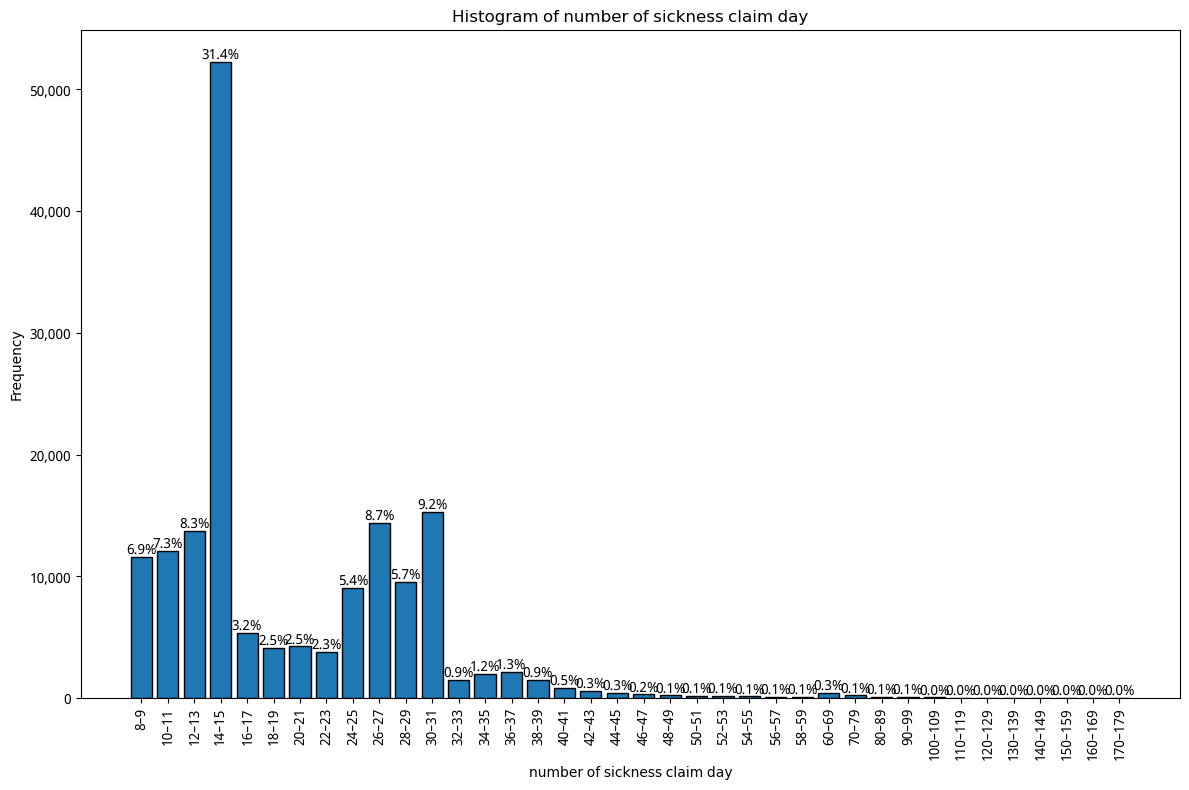

<BarContainer object of 38 artists>

In [25]:
separators = [8,60]
bins = [26,12]

bin_edges, intervals, labels = make_custom_bins(separators, bins, max_value=df5["Number_of_Day_Claim"].max(), overlap=False)

plot_binned_distribution(
    df5["Number_of_Day_Claim"], 
    bin_edges, 
    labels, 
    title="Histogram of number of sickness claim day", 
    xlabel="number of sickness claim day", 
    ylabel="Frequency",
    # hue="Hospitalization_Year",
    # data=df5,
    # hue_consecutive=True
)

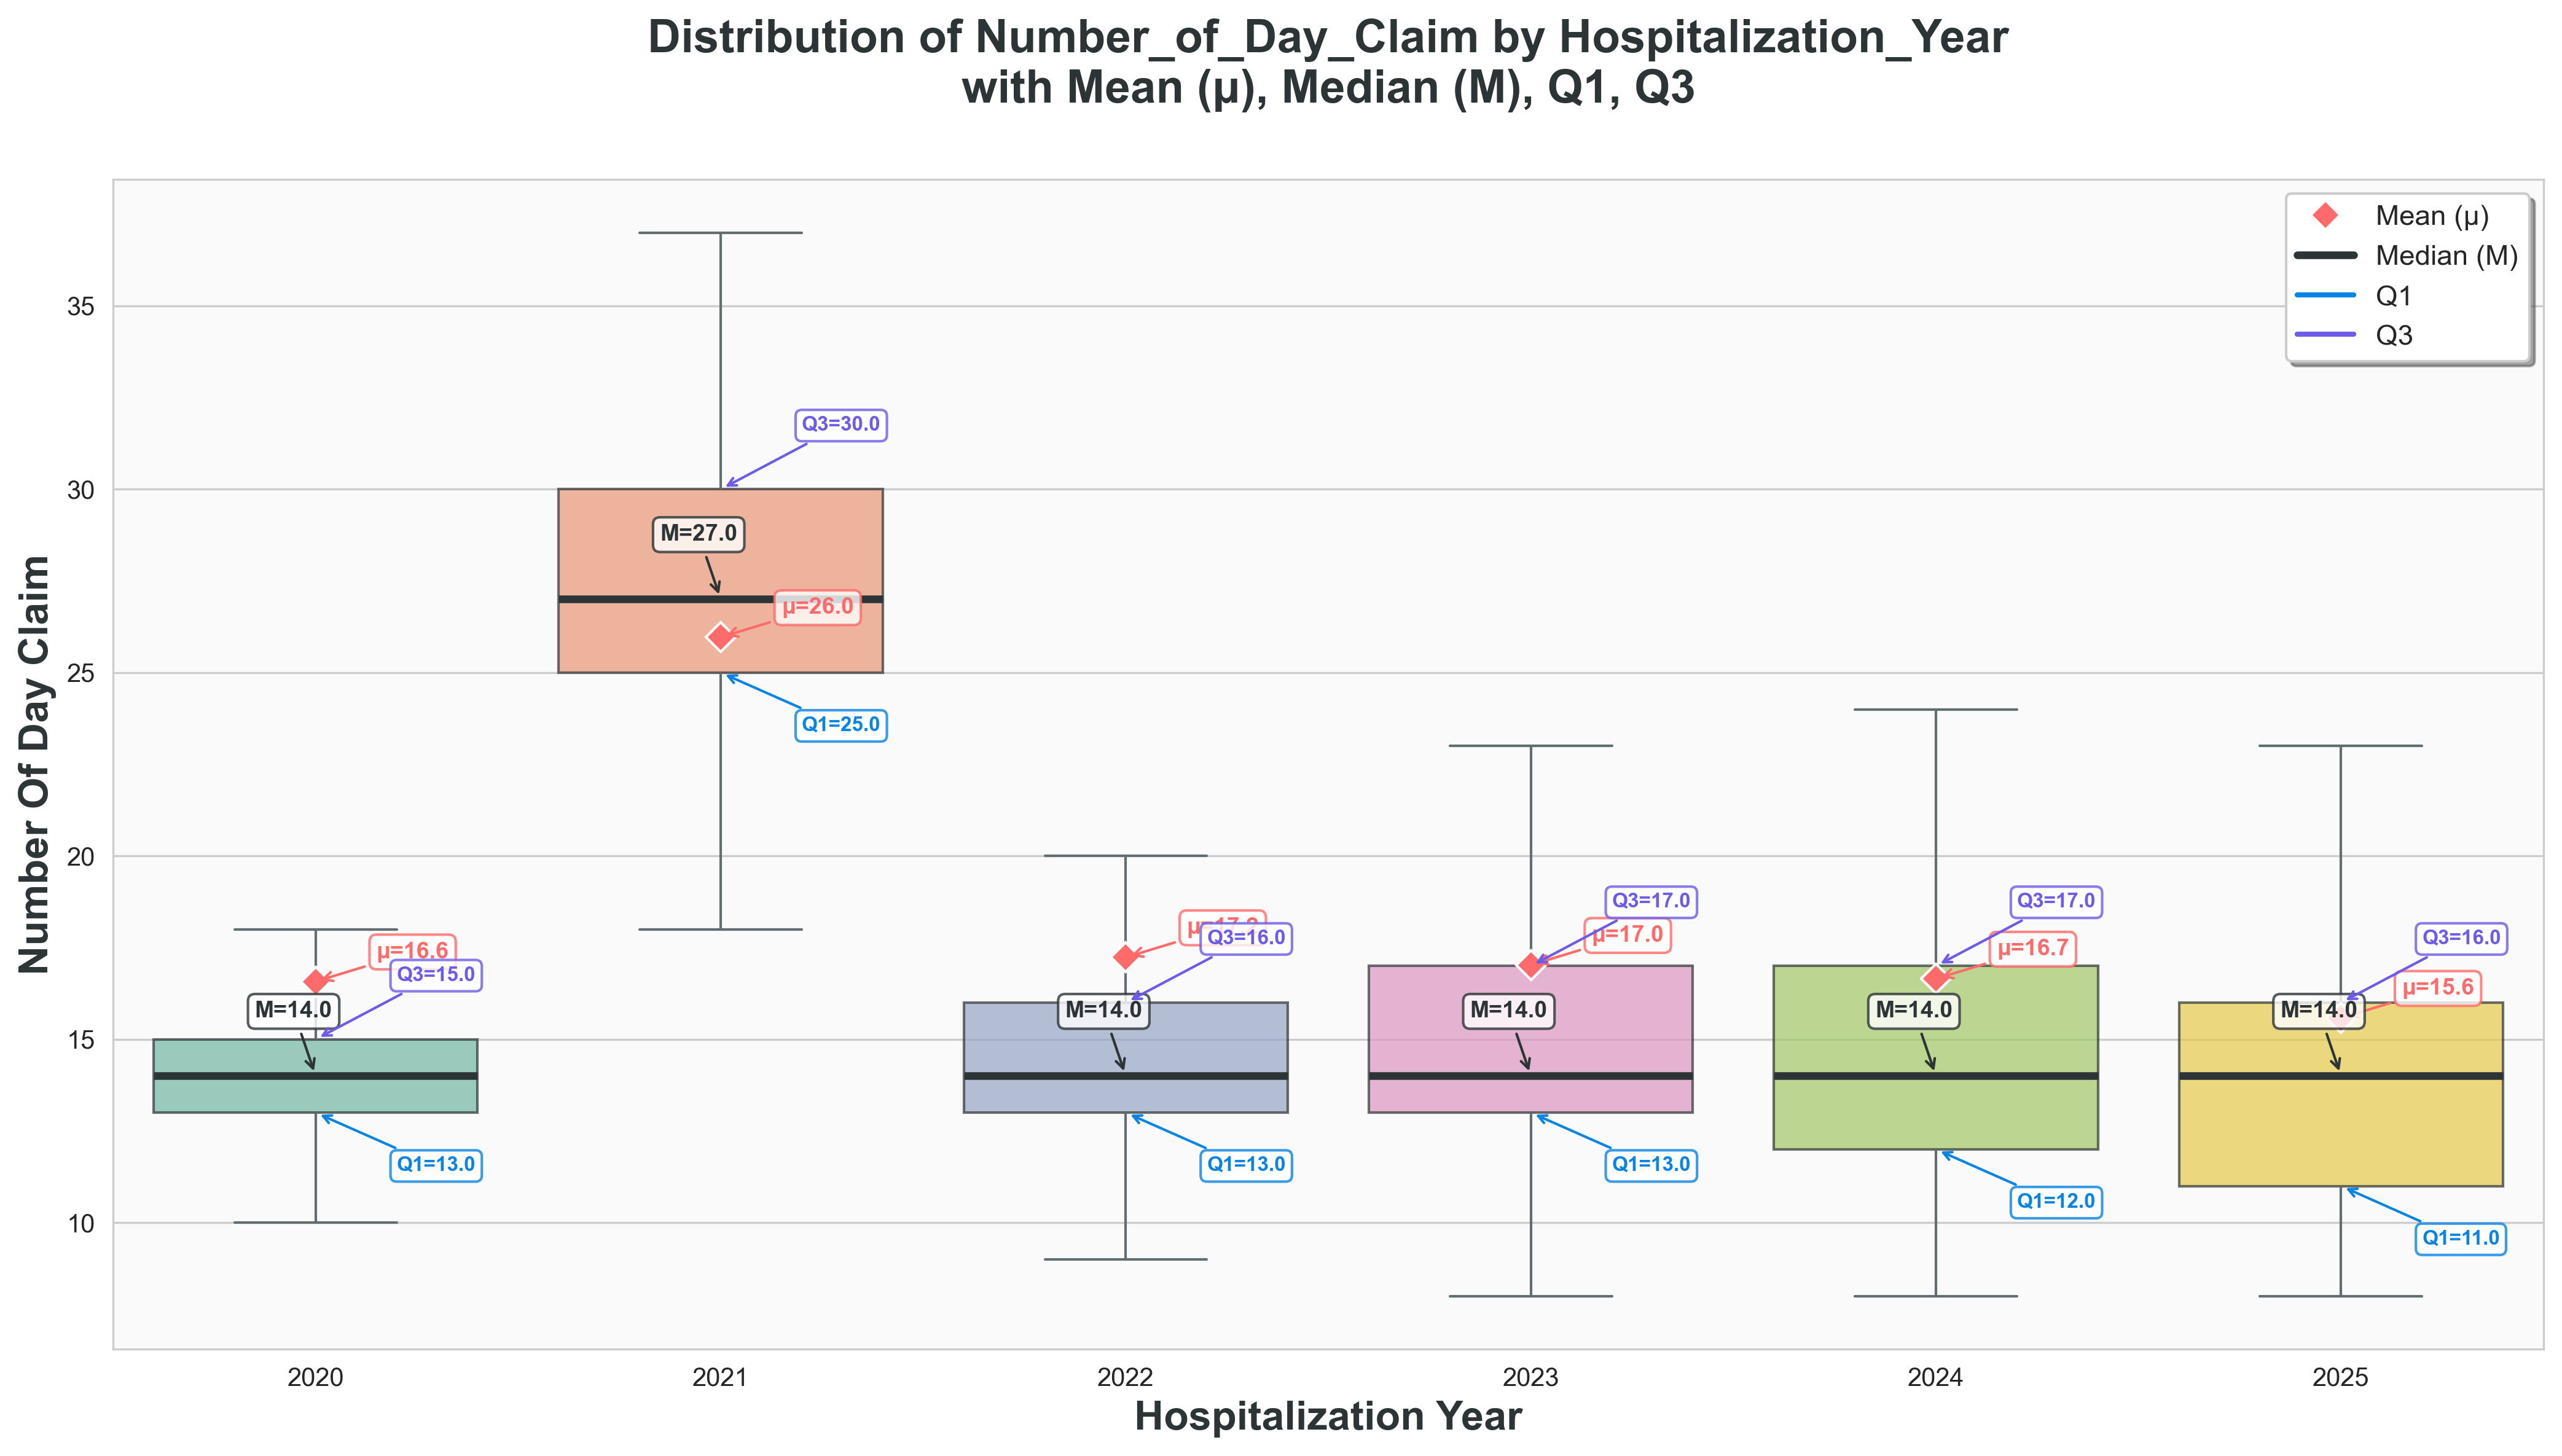

In [26]:
fig, ax = create_beautiful_boxplot(
    data=df5[df5['Hospitalization_Year'].between(2020, 2025)], 
    x_col='Hospitalization_Year', 
    y_col='Number_of_Day_Claim',
    sort_x=True
)
plt.show()


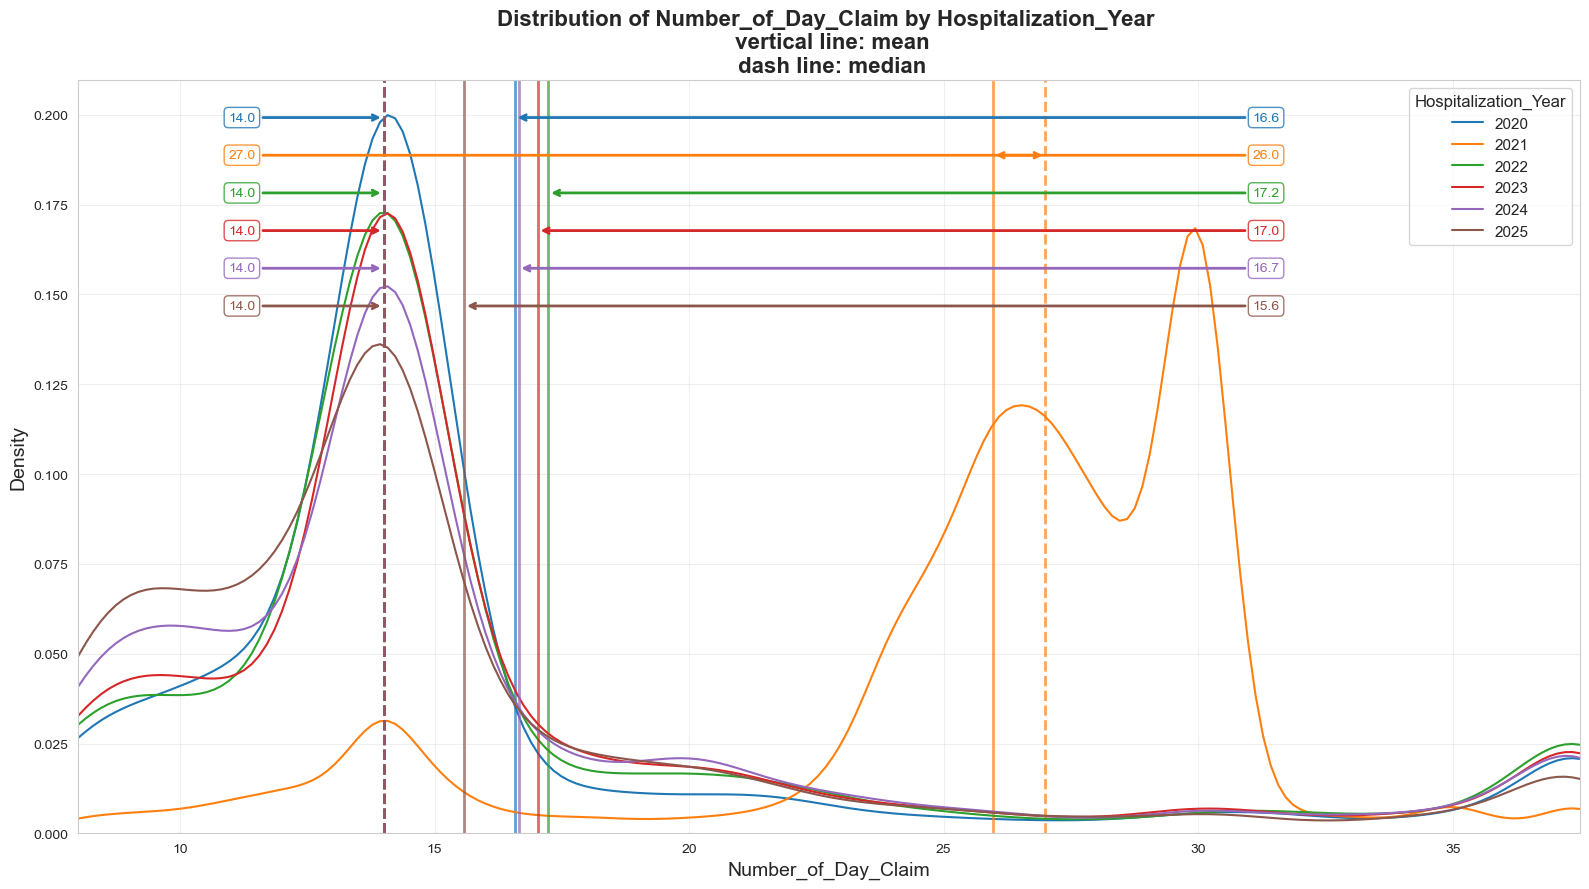

In [27]:


fig, ax = plot_distribution_curves(
    data=df5[df5['Hospitalization_Year'].between(2020, 2025)], 
    x_col='Hospitalization_Year', 
    y_col='Number_of_Day_Claim',
    cap_method='iqr'
)
plt.show()


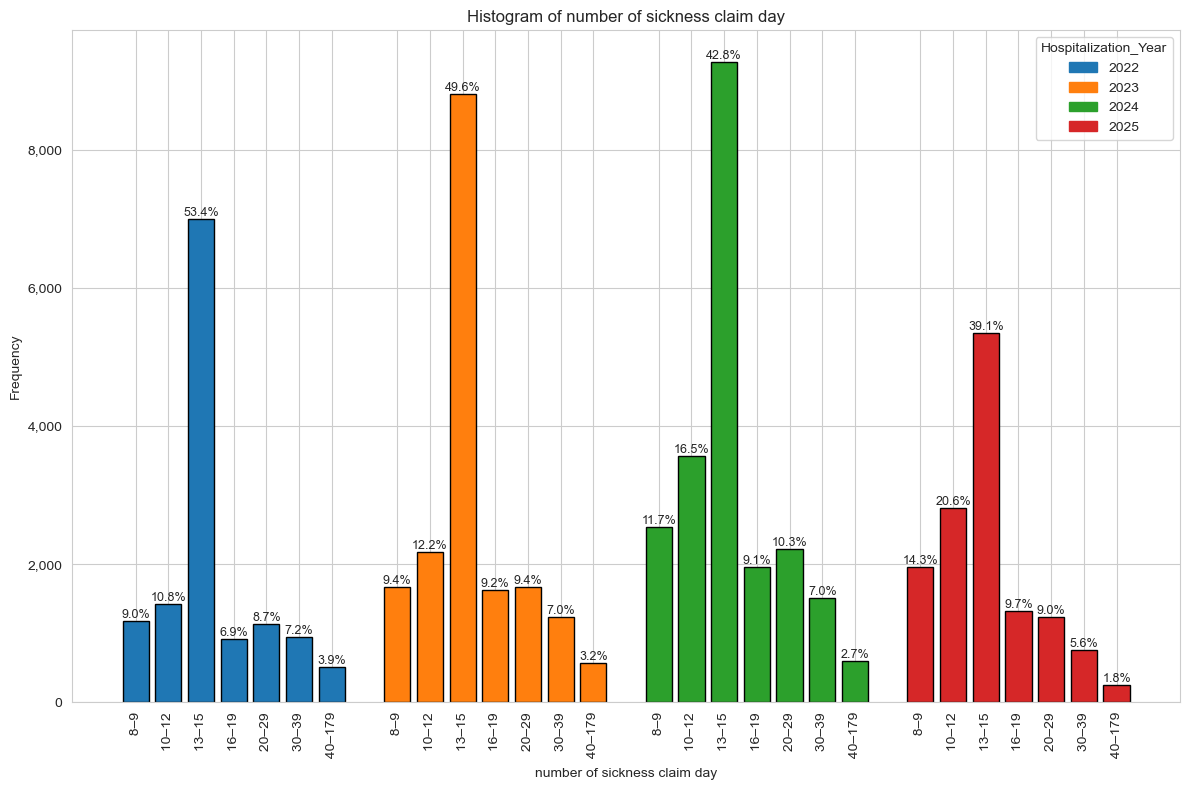

<BarContainer object of 28 artists>

In [126]:
separators = [8,10,13,16,20,30,40,180]
bins = [1,1,1,1,1,1,1]

filtered = df5[df5['Hospitalization_Year'].between(2022, 2025)]

bin_edges, intervals, labels = make_custom_bins(separators, bins, max_value=filtered.max(), overlap=False)

plot_binned_distribution(
    filtered["Number_of_Day_Claim"], 
    bin_edges, 
    labels, 
    title="Histogram of number of sickness claim day", 
    xlabel="number of sickness claim day", 
    ylabel="Frequency",
    hue='Hospitalization_Year', 
    data=filtered,
    hue_consecutive=True

)

### by HF type

In [162]:
df5[df5['Hospitalization_Year'].between(2020, 2025)]['Level of Care'].drop_duplicates()

0                NH
10      PrivateCPA1
30             CPA3
32             CPA2
49              MPA
87      PrivateCPA3
134            CPA1
158     PrivateCPA2
3832      PrivateNH
Name: Level of Care, dtype: object

In [28]:

# Create output folder if not exists
output_dir = "sickleave_boxplot"
os.makedirs(output_dir, exist_ok=True)


filtered = df5[df5['Hospitalization_Year'].between(2022, 2025)]

# Get unique combinations of Sub-Medical and Level of Care
group_combos = filtered[['Level of Care']].dropna().drop_duplicates()

for _, row in group_combos.iterrows():
    level_care = str(row['Level of Care']).strip().replace("/", "-").replace("\\", "-")
    
    # Filter df_claim for this combination
    df_filtered = filtered[filtered['Level of Care'] == row['Level of Care']
    ]
    
    if df_filtered.empty:
        continue
    
    
    fig, ax = create_beautiful_boxplot(
        data=df_filtered, 
        x_col='Hospitalization_Year', 
        y_col='Number_of_Day_Claim',
        sort_x=True
    )
        
    
    
    ax.set_title(
        f'boxplot of number sickleave day by Visit Year\n'
        f' Level of Care: {row["Level of Care"]}', 
        fontsize=14
    )
    
    # Build filename
    filename = f"{level_care}.png"
    filepath = os.path.join(output_dir, filename)
    
    # Save to PNG
    plt.savefig(filepath, bbox_inches="tight", dpi=300)
    plt.close(fig)  # Close to free memory


In [164]:

# Create output folder if not exists
output_dir = "sickleave_ditribution"
os.makedirs(output_dir, exist_ok=True)


filtered = df5[df5['Hospitalization_Year'].between(2022, 2025)]

# Get unique combinations of Sub-Medical and Level of Care
group_combos = filtered[['Level of Care']].dropna().drop_duplicates()

for _, row in group_combos.iterrows():
    level_care = str(row['Level of Care']).strip().replace("/", "-").replace("\\", "-")
    
    # Filter df_claim for this combination
    df_filtered = filtered[filtered['Level of Care'] == row['Level of Care']
    ]
    
    if df_filtered.empty:
        continue
    
    # Create plot
    fig, ax = plot_distribution_curves(
        data=df_filtered, 
        x_col='Hospitalization_Year', 
        y_col='Number_of_Day_Claim',
        cap_method='iqr')
        
    
    
    ax.set_title(
        f'distribution of number sickleave day by Visit Year\n'
        f' Level of Care: {row["Level of Care"]}', 
        fontsize=14
    )
    
    # Build filename
    filename = f"{level_care}.png"
    filepath = os.path.join(output_dir, filename)
    
    # Save to PNG
    plt.savefig(filepath, bbox_inches="tight", dpi=300)
    plt.close(fig)  # Close to free memory


## Family size

In [26]:
query7 = ''' 
 WITH family_heads AS (
    SELECT DISTINCT 
        parent_ben_key,
        parent_ben_type_id,
        CASE 
            WHEN parent_ben_type_id IN (1, 2, 3, 4, 5, 9, 10, 11, 13, 15, 16, 17) THEN N'គ្រួសារ-មន្រ្តីសាធារណៈ'
            WHEN parent_ben_type_id IN (6) THEN N'គ្រួសារ-កម្មករនិយោជិត'
            WHEN parent_ben_type_id IN (12) THEN N'គ្រួសារ-បុគ្គលស្វ័យនិយោជន៍'
            ELSE N'others'
        END AS parent_target_group,
        CASE 
            WHEN parent_ben_type_id IN (1, 2, 3, 4, 5, 9, 10, 11, 13, 15, 16, 17) THEN 11
            WHEN parent_ben_type_id IN (6) THEN 22
            WHEN parent_ben_type_id IN (12) THEN 33
            ELSE 00
        END AS parent_target_group_alias
    FROM [DM_REG].[dmrc].[dm_beneficiary_dependent]
),

dependent_counts AS (
    SELECT 
        parent_ben_key,
        COUNT(ben_key) AS dep_count
    FROM [DM_REG].[dmrc].[dm_beneficiary_dependent]
    GROUP BY parent_ben_key
),

family_sizes AS (
    SELECT 
        fh.parent_ben_key,
        fh.parent_target_group_alias,
        fh.parent_target_group,
        ISNULL(dc.dep_count, 0) + 1 AS no_family_member
    FROM family_heads fh
    LEFT JOIN dependent_counts dc ON fh.parent_ben_key = dc.parent_ben_key
)


select *
FROM family_sizes
'''

In [27]:

df7 = pd.read_sql(query7, conn)

C:\Users\DELL\AppData\Local\Temp\ipykernel_47528\706804099.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df7 = pd.read_sql(query7, conn)


### all


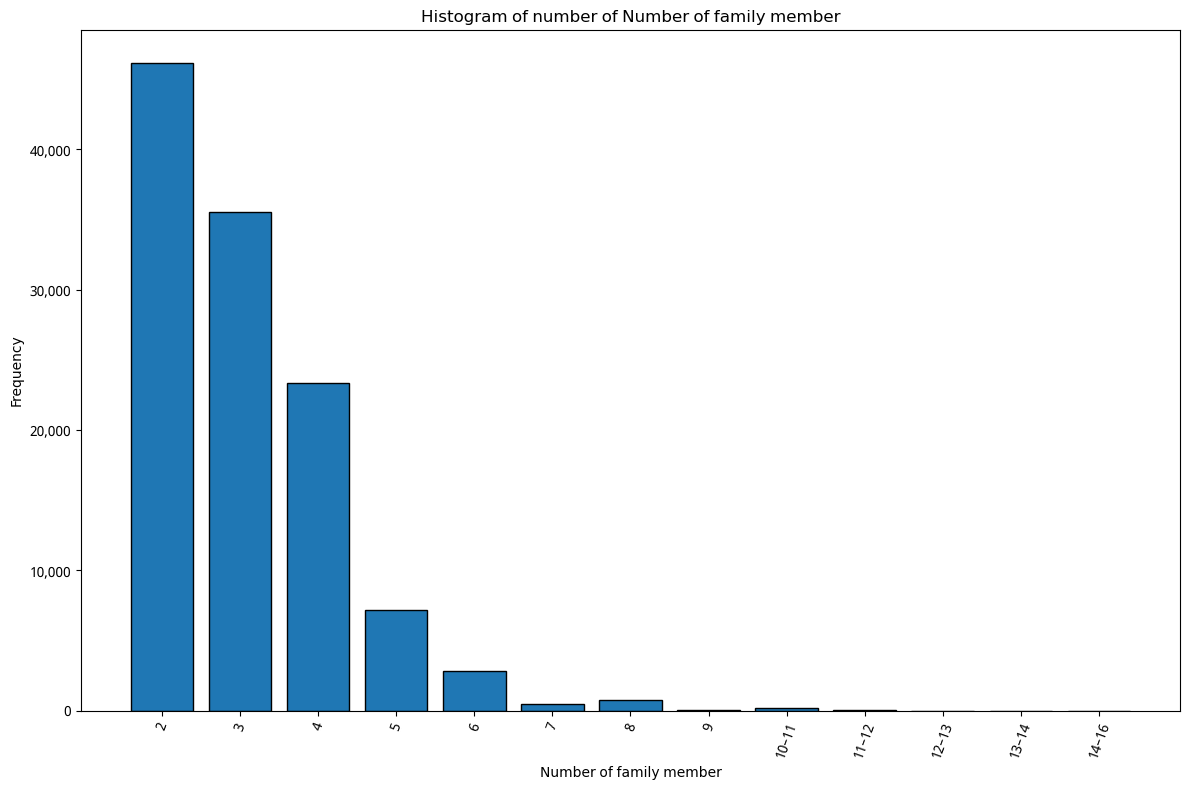

In [28]:
bin_edges, intervals, labels = make_custom_bins(
    ranges=[2, 10],
    bins_per_range=[8, 5],
    max_value=df7["no_family_member"].max(),
    collapse_unit_bins=True
)


plot_binned_distribution(
    series=df7["no_family_member"], 
    bin_edges=bin_edges, 
    labels=labels, 
    title="Histogram of number of Number of family member", 
    xlabel="Number of family member", 
    ylabel="Frequency",
    
)

### by target

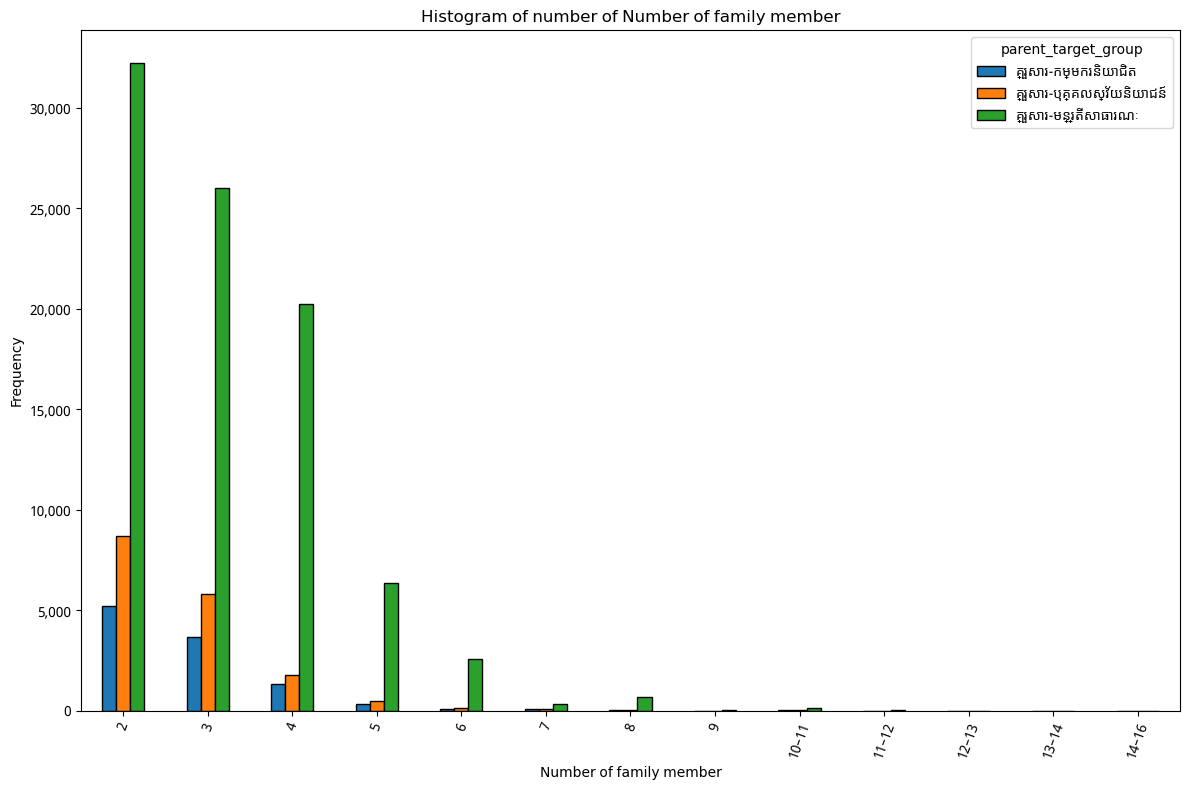

In [29]:

plot_binned_distribution(
    series=df7["no_family_member"], 
    bin_edges=bin_edges, 
    labels=labels, 
    title="Histogram of number of Number of family member", 
    xlabel="Number of family member", 
    ylabel="Frequency",
    hue ="parent_target_group",
    data= df7
)

### stat

In [ ]:
percentiles = [.25, .5, .75, .9, .95, .99]

summary = df7["no_family_member"].describe(percentiles=percentiles)

summary.to_clipboard()
summary

count   116,655.00
mean          3.07
std           1.20
min           2.00
25%           2.00
50%           3.00
75%           4.00
90%           4.00
95%           5.00
99%           7.00
max          16.00
Name: no_family_member, dtype: float64

In [32]:

percentiles = [.25, .5, .75, .9, .95, .99]

summary = (
    df7.groupby("parent_target_group")["no_family_member"]
       .describe(percentiles=percentiles)
)

summary.to_clipboard()
summary


,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
parent_target_group,,,,,,,,,,,
គ្រួសារ-កម្មករនិយោជិត,"10,795.00",2.80,1.08,2.00,2.00,3.00,3.00,4.00,5.00,7.00,15.00
គ្រួសារ-បុគ្គលស្វ័យនិយោជន៍,"17,125.00",2.72,0.99,2.00,2.00,2.00,3.00,4.00,4.00,6.00,16.00
គ្រួសារ-មន្រ្តីសាធារណៈ,"88,735.00",3.17,1.23,2.00,2.00,3.00,4.00,5.00,5.00,8.00,14.00




# misc

In [126]:
test = pd.read_csv("test.csv")

In [127]:
test1 = extract_english_only(test, columns=['sub_lvl_care'])

In [135]:
pandas(test.sub_lvl_care.unique())

NameError: name 'pandas' is not defined

In [136]:
unique_values = pd.DataFrame(test['sub_lvl_care'].unique(), columns=['sub_lvl_care'])

# Copy to clipboard
unique_values.to_clipboard(index=False)

In [129]:
test1

,sub_lvl_care,clean_sub_lvl_care,case_name,record_count,total_amount,avg_amount,min_amount,max_amount,median_amount
0,CPA1,CPA1,0-10km1,21,630000,"30,000.00",30000,30000,30000
1,CPA1,CPA1,0-40KM1,3,300000,"100,000.00",100000,100000,100000
2,CPA3,CPA3,0-5km3,2,80000,"40,000.00",40000,40000,40000
3,CPA1,CPA1,11-20km1,25,2000000,"80,000.00",80000,80000,80000
4,CPA2,CPA2,11-20km2,4,320000,"80,000.00",80000,80000,80000
...,...,...,...,...,...,...,...,...,...
848,CPA3,CPA3,5,34,1088000,"32,000.00",32000,32000,32000
849,CPA3,CPA3,VC6,15,570000,"38,000.00",38000,38000,38000
850,CPA3,CPA3,5,4,160000,"40,000.00",40000,40000,40000
851,CPA3,CPA3,5,23,1150000,"50,000.00",50000,50000,50000


In [101]:
base_dir = "amount_data_parquet_test"

# Read all parquet files recursively
df_ffs_test = pd.read_parquet(base_dir, engine="pyarrow")



In [102]:
df_ffs_test = df_ffs_test[df_ffs_test.Total_Amount_FFS != 0]

In [103]:
df_ffs_test

,Visit_Year,Visit_Month,Total_Amount_FFS,Total_Amount_CB,Total_Amount,Detail_Medical,sub_lvl_care,visit_year
0,2024,1,"60,000.00",0.00,"60,000.00",សេវាទូទាត់ជាកញ្ចប់ FFS Package,មន្ទីរពេទ្យមិត្តភាពខ្មែរ-សូវៀត NH_Khmer-Soviet...,2024
1,2024,1,"160,000.00",0.00,"160,000.00",សេវាទូទាត់ជាកញ្ចប់ FFS Package,មន្ទីរពេទ្យមិត្តភាពខ្មែរ-សូវៀត NH_Khmer-Soviet...,2024
2,2024,1,"160,000.00",0.00,"160,000.00",សេវាទូទាត់ជាកញ្ចប់ FFS Package,មន្ទីរពេទ្យមិត្តភាពខ្មែរ-សូវៀត NH_Khmer-Soviet...,2024
3,2024,1,"60,000.00",0.00,"60,000.00",សេវាទូទាត់ជាកញ្ចប់ FFS Package,មន្ទីរពេទ្យមិត្តភាពខ្មែរ-សូវៀត NH_Khmer-Soviet...,2024
4,2024,1,"160,000.00",0.00,"160,000.00",សេវាទូទាត់ជាកញ្ចប់ FFS Package,មន្ទីរពេទ្យមិត្តភាពខ្មែរ-សូវៀត NH_Khmer-Soviet...,2024
...,...,...,...,...,...,...,...,...
3895010,2024,6,"66,700.00","120,000.00","186,700.00",ពិគ្រោះជំងឺក្រៅ OPD Consultation,មន្ទីរពេទ្យកាល់ម៉ែត NH_Calmette,2024
3895051,2024,6,"487,400.00","120,000.00","607,400.00",ពិគ្រោះជំងឺក្រៅ OPD Consultation,មន្ទីរពេទ្យកាល់ម៉ែត NH_Calmette,2024
3895062,2024,6,"560,000.00","120,000.00","680,000.00",ពិគ្រោះជំងឺក្រៅ OPD Consultation,មន្ទីរពេទ្យកាល់ម៉ែត NH_Calmette,2024
3895070,2024,6,"32,200.00","120,000.00","152,200.00",ពិគ្រោះជំងឺក្រៅ OPD Consultation,មន្ទីរពេទ្យកាល់ម៉ែត NH_Calmette,2024


In [104]:
df_ffs_test = extract_english_only(df_ffs_test)

In [105]:
df_ffs_test

,Visit_Year,Visit_Month,Total_Amount_FFS,Total_Amount_CB,Total_Amount,Detail_Medical,sub_lvl_care,visit_year
0,2024,1,"60,000.00",0.00,"60,000.00",FFS Package,NH_Khmer-Soviet Friendship NH,2024
1,2024,1,"160,000.00",0.00,"160,000.00",FFS Package,NH_Khmer-Soviet Friendship NH,2024
2,2024,1,"160,000.00",0.00,"160,000.00",FFS Package,NH_Khmer-Soviet Friendship NH,2024
3,2024,1,"60,000.00",0.00,"60,000.00",FFS Package,NH_Khmer-Soviet Friendship NH,2024
4,2024,1,"160,000.00",0.00,"160,000.00",FFS Package,NH_Khmer-Soviet Friendship NH,2024
...,...,...,...,...,...,...,...,...
3895010,2024,6,"66,700.00","120,000.00","186,700.00",OPD Consultation,NH_Calmette,2024
3895051,2024,6,"487,400.00","120,000.00","607,400.00",OPD Consultation,NH_Calmette,2024
3895062,2024,6,"560,000.00","120,000.00","680,000.00",OPD Consultation,NH_Calmette,2024
3895070,2024,6,"32,200.00","120,000.00","152,200.00",OPD Consultation,NH_Calmette,2024


In [107]:
df_pivot = df_ffs_test.groupby(["sub_lvl_care", "Detail_Medical"])["Total_Amount_FFS"].mean().reset_index()
df_pivot.to_clipboard()

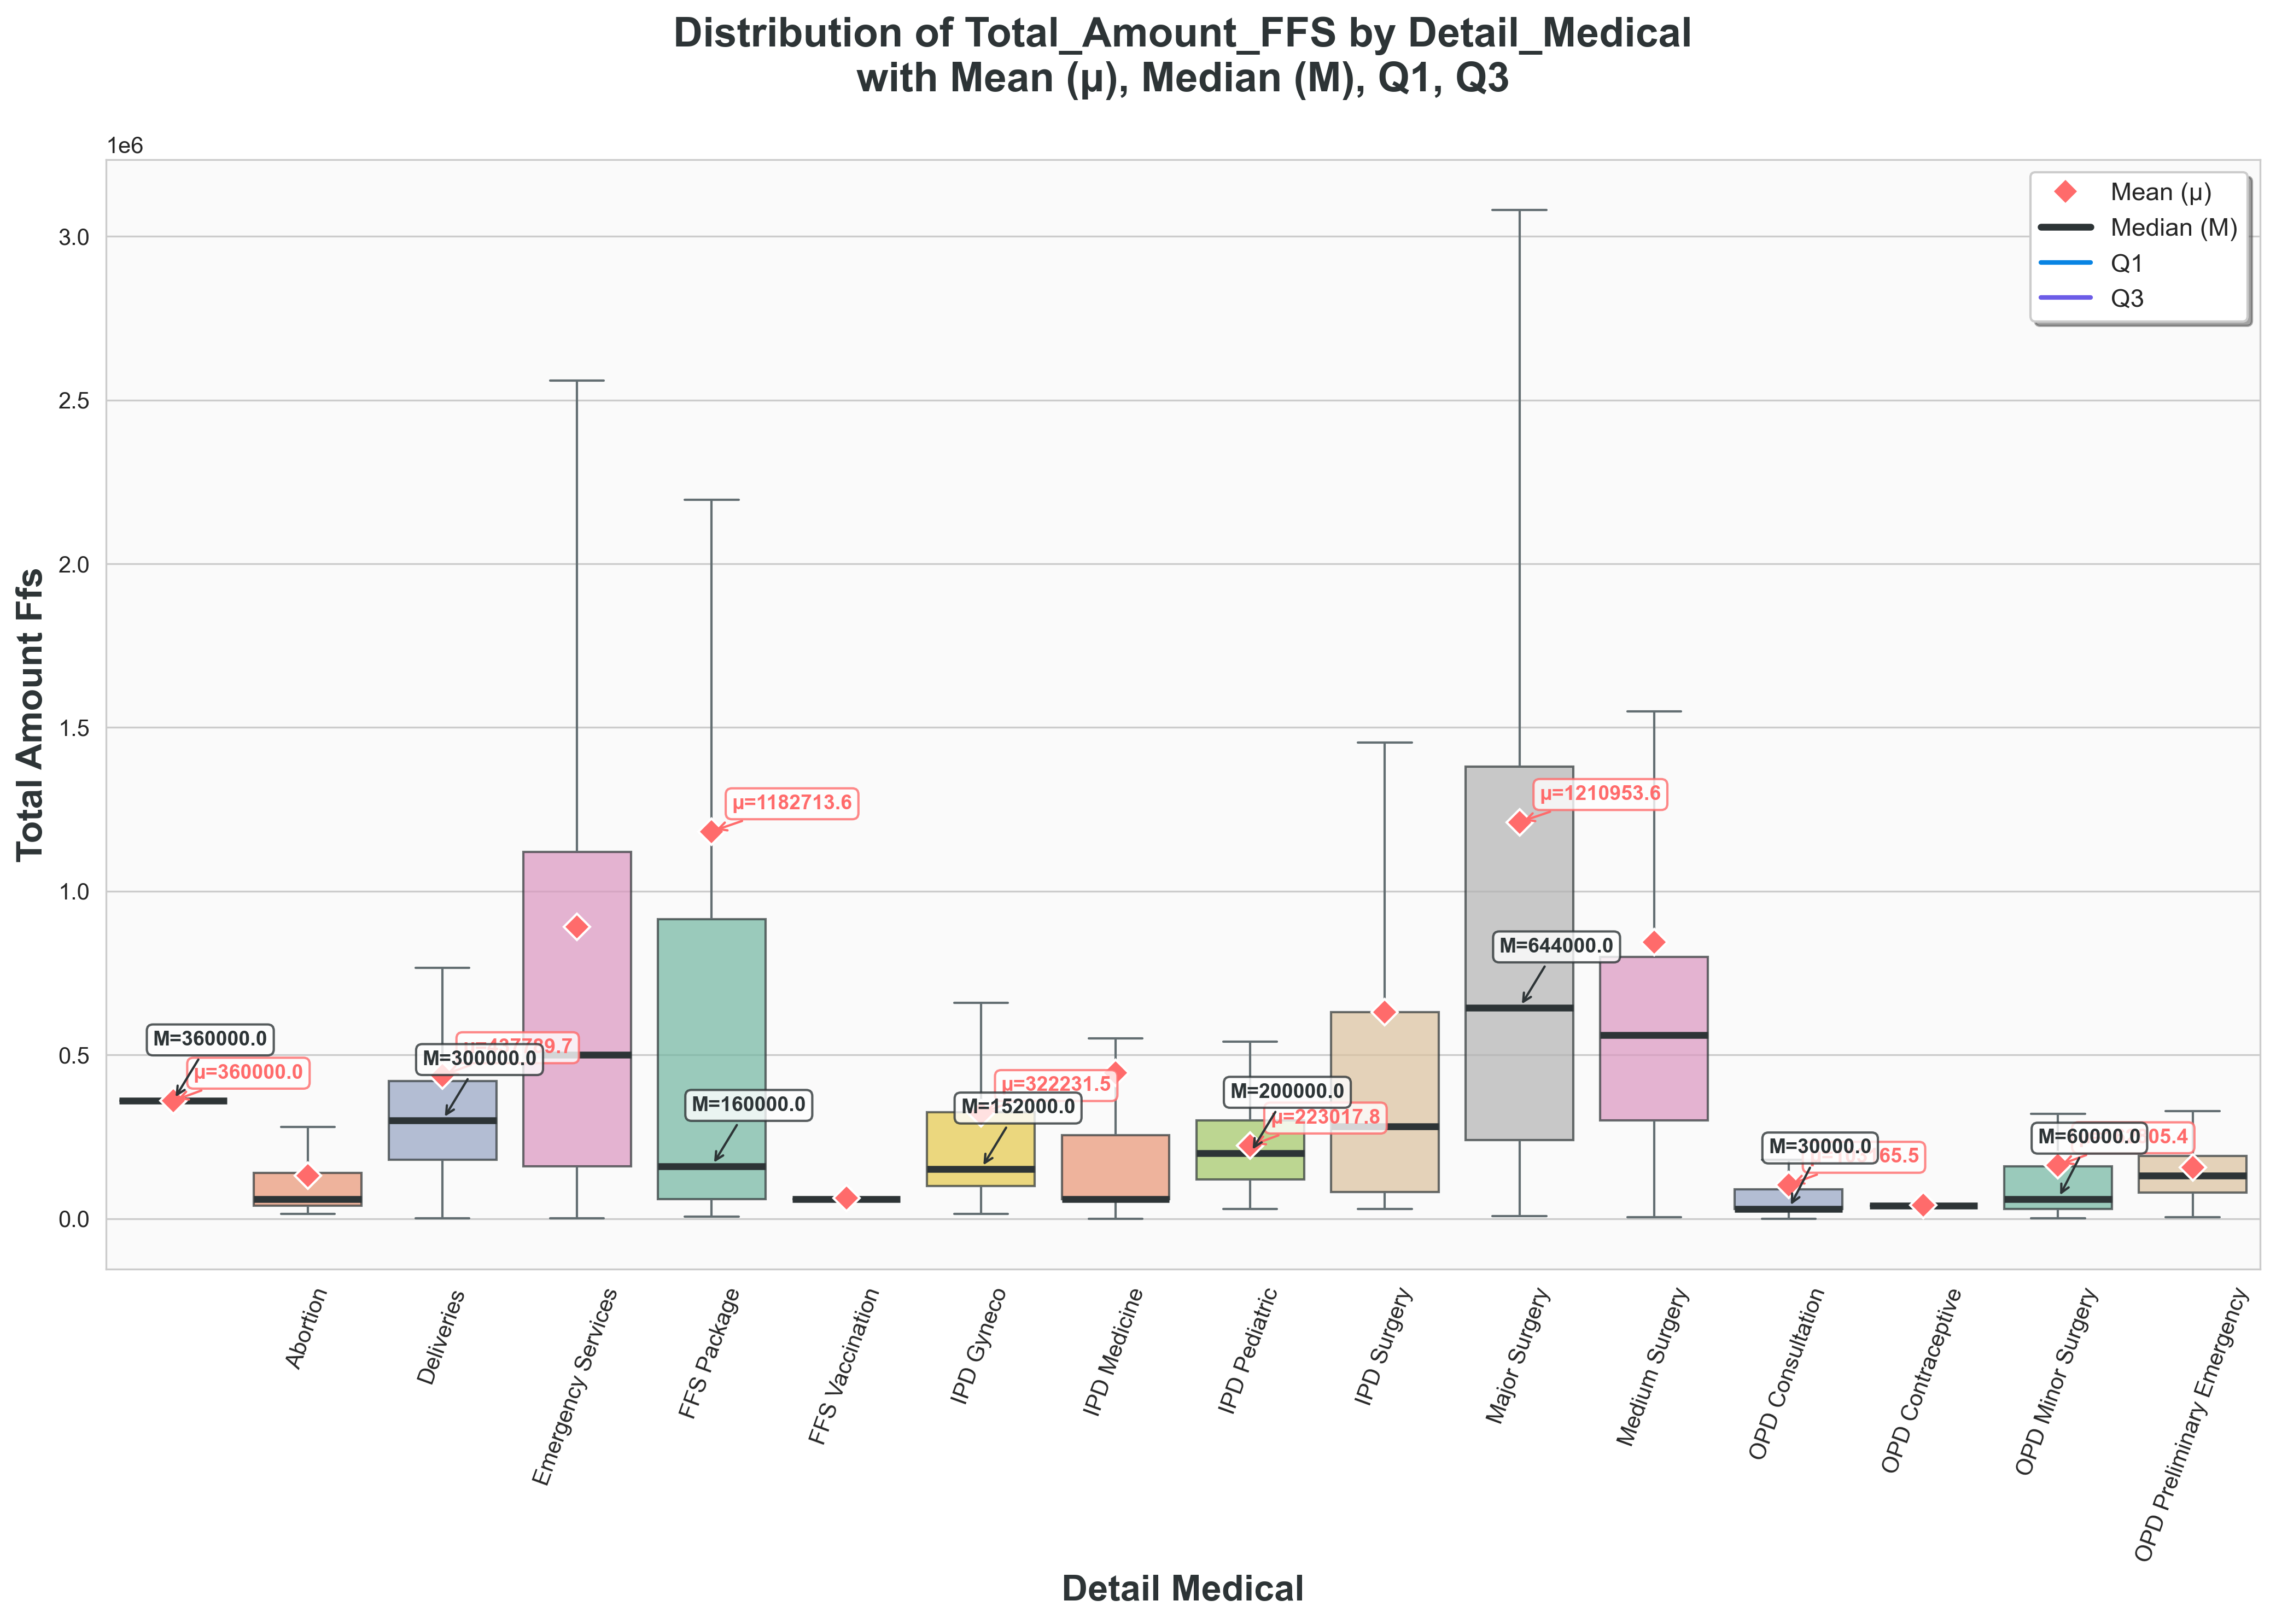

In [95]:
   
fig, ax = create_beautiful_boxplot(
    data=df_ffs_test, 
    x_col='Detail_Medical', 
    y_col='Total_Amount_FFS',
    sort_x=True
    ,figsize=(14,10)
)

In [64]:
sub_medicals = df_ffs_test['Detail_Medical'].unique()

In [65]:
sub_medicals

array(['FFS Package', 'IPD Medicine', 'Deliveries', 'Emergency Services',
       'FFS Vaccination', 'IPD Gyneco', 'IPD Surgery', 'Major Surgery',
       'OPD Minor Surgery', 'Abortion', 'OPD Consultation',
       'Medium Surgery', 'IPD Pediatric', '', 'OPD Preliminary Emergency',
       'OPD Contraceptive'], dtype=object)

In [110]:

output_folder = "./boxplots_FFS"
os.makedirs(output_folder, exist_ok=True)

sub_medicals = df_ffs_test['Detail_Medical'].unique()

for sub_med in sub_medicals:
    # Filter df_claim for this Sub-Medical
    df_filtered = df_ffs_test[df_ffs_test['Detail_Medical'] == sub_med]
    
    # Skip empty dataframes
    if df_filtered.empty:
        continue
        
    fig, ax = create_beautiful_boxplot(
        data=df_filtered, 
        x_col='sub_lvl_care', 
        y_col='Total_Amount_FFS',
        sort_x=True,
        show_annotations=True,
        figsize=(14,16)
    )

    ax.set_title(f'Boxplot of FFS Amount by sub level of care\nSub-Medical: {sub_med}', fontsize=16)
    
    # Clean filename (remove invalid characters)
    filename = f"{sub_med}".replace(" ", "_").replace("/", "_")
    file_path = os.path.join(output_folder, f"{filename}.png")
    
    fig.savefig(file_path, dpi=300, bbox_inches='tight')  # save figure
    plt.close(fig)  # close figure to free memory
